# Clasificación de animales mediante el análisis de imágenes de fototrampeo.

El objetivo de este proyecto es crear un sistema que nos permita clasificar animales.


# 1.0 Preparación de entorno.

Preparación del entorno de trabajo. Con la importación de las librerías necesarias

In [1]:
# Nos aseguramos que usamos TensorFlow
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Comprobamos si está disponible la GPU
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.10.0
TF Hub version: 0.12.0
GPU available


In [125]:
# Importamos las librerías
import random
import pandas as pd
import numpy as np
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from tensorflow import keras
from pathlib import Path
import os
import csv
import seaborn as sns
import cv2
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.colors as mcolors

from IPython.display import Image
from tensorflow.keras.layers import BatchNormalization,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

Una vez importadas las librerías, subir al entorno de colab los datos con los que vamos a trabajar. Las imágenes las tenemos comprimidas en un archivo en Drive, por lo que será necesario conectar Drive con Colab y descomprimir las imágenes en el servidor de Colab para poder trabajar con ellas.

Para familiarizarnos con el tipo de imagen que vamos a usar en el proyecto, graficamos una de ellas usando la librería `Image`, a la que le pasamos la ruta de la imagen:

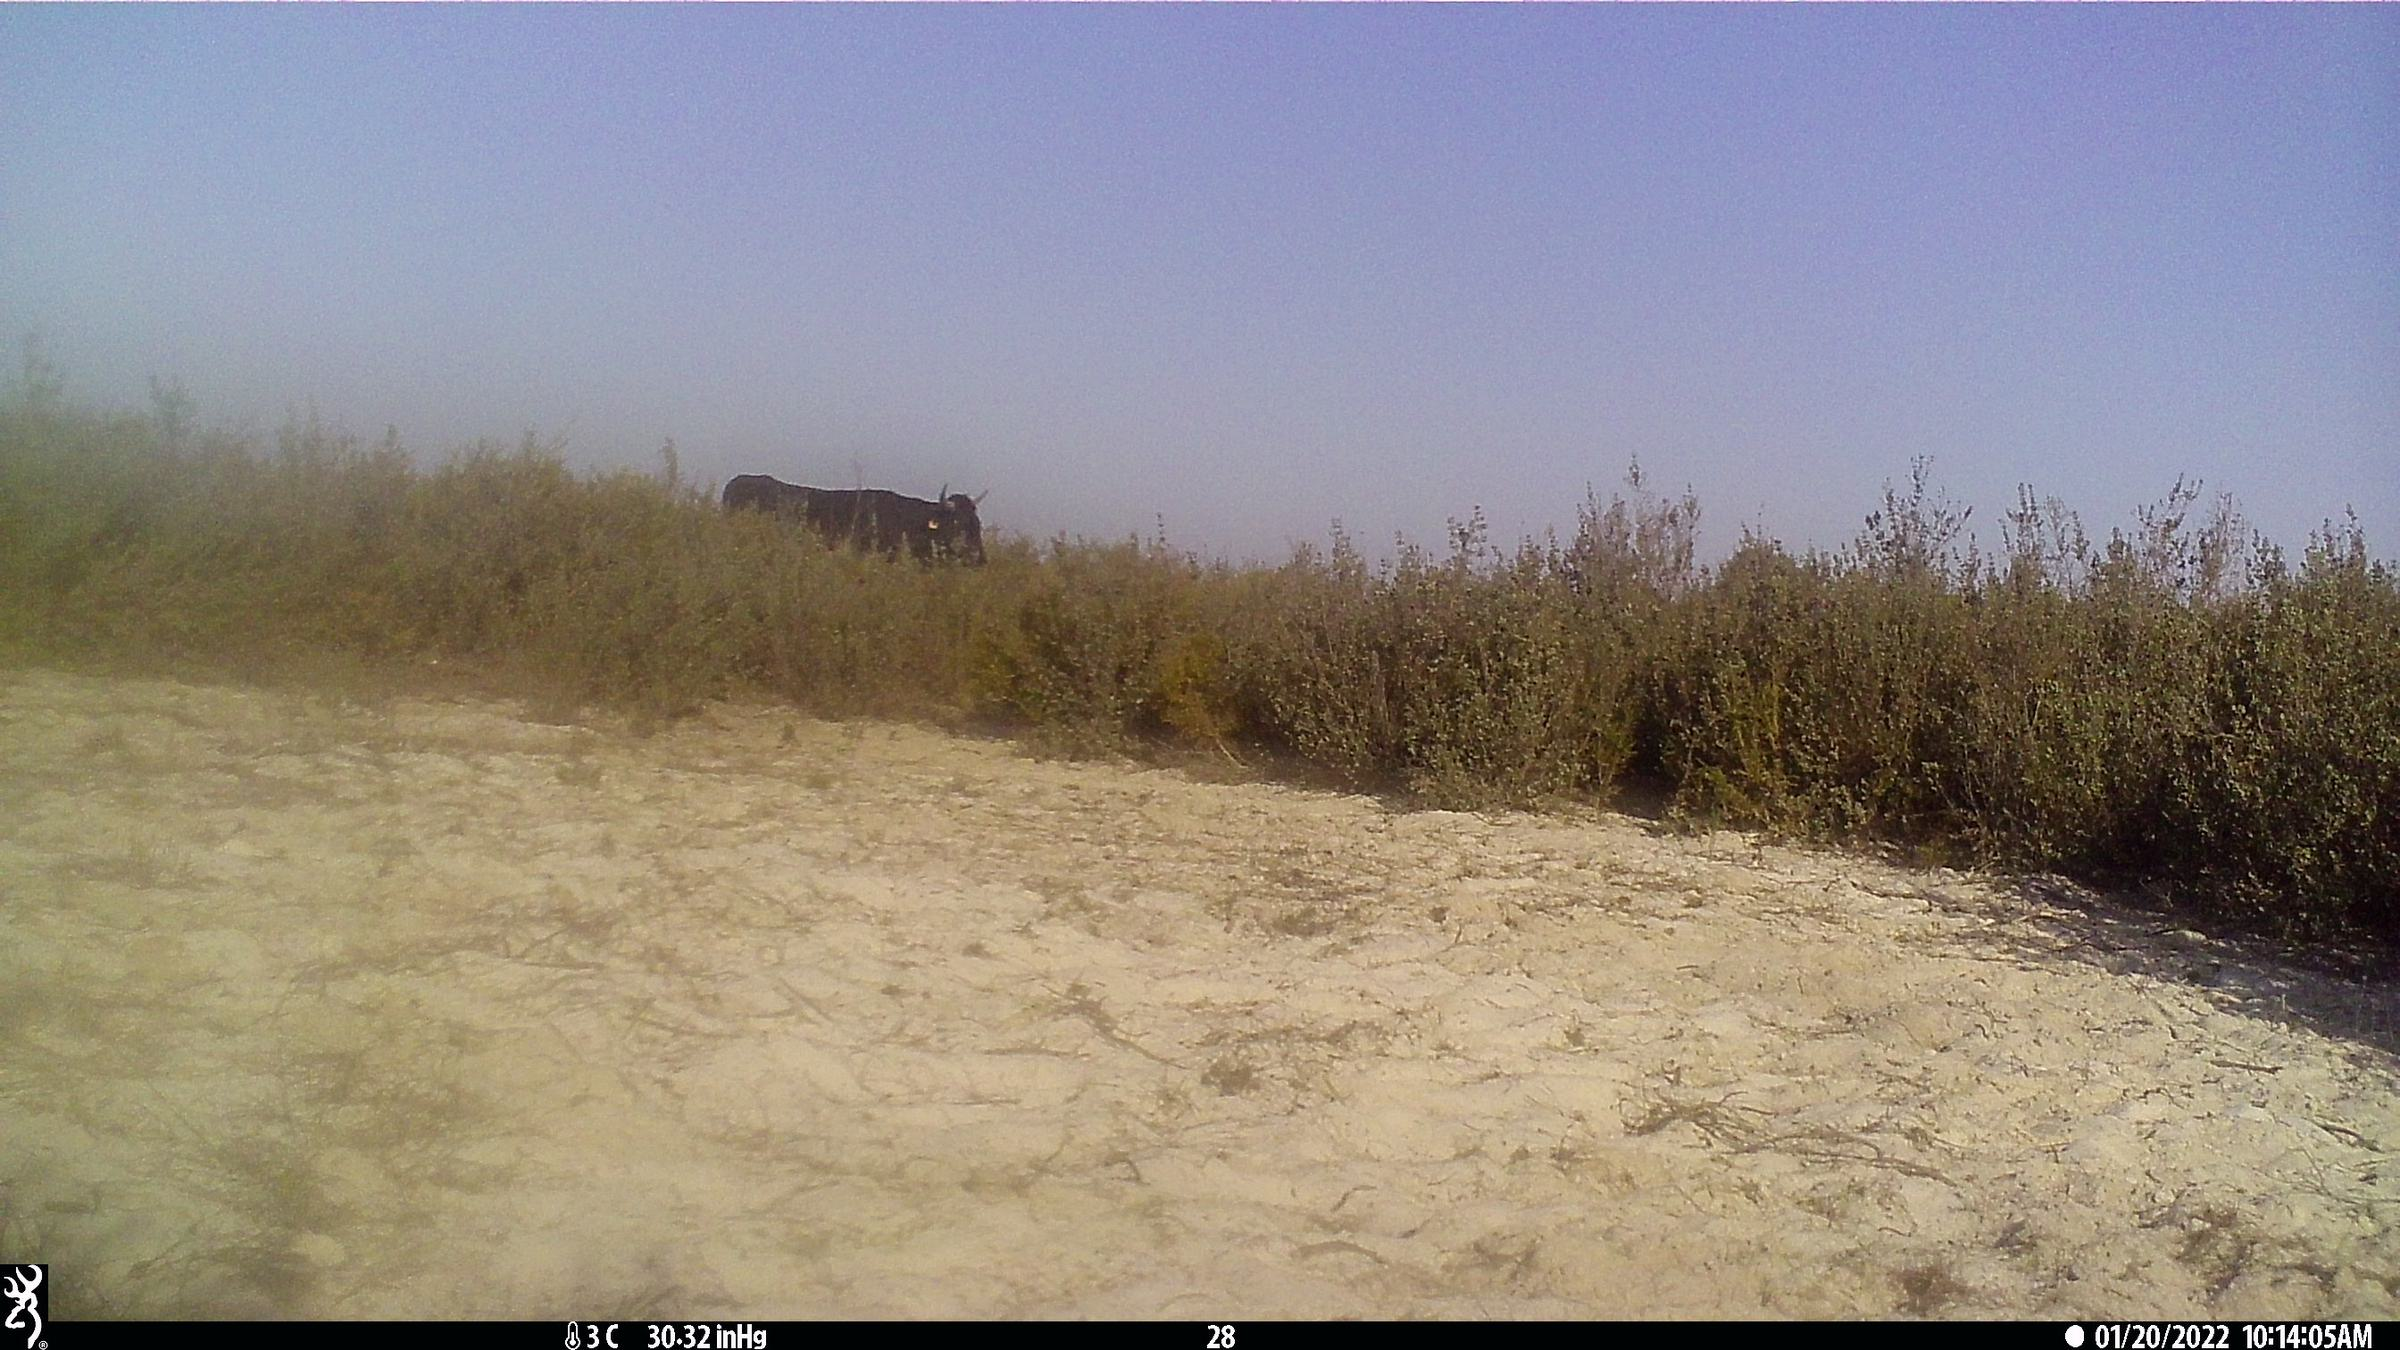

In [126]:
Image("dataset/rev15/28/28_20220120 (1246).JPG")

Podemos ver que cada imagen contiene una fotografía animal. En este caso, se puede ver que es una vaca.

## 1.1 Creación del DataFrame con la información necesaria.

Como se ha comentado previamente, el nombre de cada imagen contiene la fecha y hora en la que fue tomada, además de la cámara y el número de foto. La foto se encuentra dentro de la carpeta que corresponde a la cámara, que a su vez se encuentra dentro de la carpeta de la revisión correspondiente. Estas se encuentran dentro de una carpeta con el nombre del animal que se encuentra en la imagen.

Para poder explorar los datos y usarlos posteriormente en la fase de diseño del modelo, vamos a crear un dataframe que contenga toda esta información.

La información que neceistaremos se encuentra en el CSV del dataset:
- path
- label

Antes de proceder con la creación del dataframe, vamos a definir una función que extraerá del csv esta información. Esta función devolverá un dataframe con toda la información que se ha extraído.

Para ello, la función recibe como parámetro la siguiente información:

* Path: ruta donde se encuentran almacenado el CSV.

In [127]:
def read_CSV(inputcsv):
    """
    Lee el CSV a procesar y extrae la información de él (paths y labels)
    """
    # lee el csv a procesar

    # los datos que obtiene del csv directamente en un dataframe
    df = pd.read_csv(inputcsv,
                     names = ["Image Path", "Label"])
    # arr = df.to_numpy()

    return df

Creamos el dataframe con la información de todas las imágenes del dataset. Para ello, pasamos a la función creada anteriormente la ruta donde se encuentran las imágenes:

In [128]:
Folder = "CSVs/"

CSV_NAME = "c01_TOY_reduced"

CSV = Folder + CSV_NAME + ".csv"

assert (os.path.isfile(CSV)), "El csv introducido no existe"

# La variable csv_path contiene la ruta donde se encuentran las imágenes
csv_path = CSV

# Pasamos la variable path_images como parámetro a la función create_dataframe, que nos devuelve el dataframe creado. Lo guardamos en la variable df
df = read_CSV(inputcsv = csv_path)

Observamos las primeras 20 filas del dataframe creado:

In [129]:
df[:20]

,Image Path,Label
0,rev09/49/49_20210704 (24833).JPG,EMPTY
1,rev08/20/20_20210529 (16059).JPG,EMPTY
2,rev13/18/18_20211024 (3094).JPG,EMPTY
3,rev09/5/5_20210709 (6191).JPG,EMPTY
4,rev13/32/32_20211026 (4008).JPG,EMPTY
5,rev05/2/2_20210303 (2136).JPG,EMPTY
6,rev07/2/2_20210501 (20959).JPG,EMPTY
7,rev07/2/2_20210502 (23065).JPG,EMPTY
8,rev14/4/4_20211217 (13350).JPG,EMPTY
9,rev08/24/24_20210517 (6173).JPG,EMPTY


Antes de pasar al análisis de los datos, vamos a comprobar que no nos hayamos dejado alguna imagen en el proceso de crear el dataframe. Para ello, vamos a generar los nombres de los archivos del árbol del directorio donde se encuentran las imágenes descomprimidas, con ayuda del método os.walk() de Python. Con esto, obtendremos el número de imágenes descomprimidas que se encuentran en el directorio y podremos comprobar si tenemos el mismo número de registros en el dataframe.

In [141]:
# Comprobamos el número de imágenes descomprimidas en el directorio. Este dato se guarda en la variable filename

all_filenames = []

for dirpath, dirnames, filenames in os.walk("dataset"):
  print(f"Hay {len(dirnames)} directorio y {len(filenames)} imagenes en '{dirpath}'.")
  #print(filenames)
  for file in filenames:
      # comprueba que sea una imagen .jpg
      if file.split(".")[-1] == "JPG":
          all_filenames.append(file)

Hay 15 directorio y 0 imagenes en 'dataset'.
Hay 36 directorio y 0 imagenes en 'dataset\rev01'.
Hay 0 directorio y 14 imagenes en 'dataset\rev01\10'.
Hay 0 directorio y 44 imagenes en 'dataset\rev01\11'.
Hay 0 directorio y 62 imagenes en 'dataset\rev01\12'.
Hay 0 directorio y 39 imagenes en 'dataset\rev01\13'.
Hay 0 directorio y 40 imagenes en 'dataset\rev01\14'.
Hay 0 directorio y 152 imagenes en 'dataset\rev01\15'.
Hay 0 directorio y 18 imagenes en 'dataset\rev01\16'.
Hay 0 directorio y 64 imagenes en 'dataset\rev01\17'.
Hay 0 directorio y 21 imagenes en 'dataset\rev01\18'.
Hay 0 directorio y 5 imagenes en 'dataset\rev01\19'.
Hay 0 directorio y 70 imagenes en 'dataset\rev01\20'.
Hay 0 directorio y 638 imagenes en 'dataset\rev01\21'.
Hay 0 directorio y 13 imagenes en 'dataset\rev01\22'.
Hay 0 directorio y 10 imagenes en 'dataset\rev01\23'.
Hay 0 directorio y 80 imagenes en 'dataset\rev01\24'.
Hay 0 directorio y 56 imagenes en 'dataset\rev01\25'.
Hay 0 directorio y 126 imagenes en 'dat

In [142]:
def check_missing_files(all_filenames, df):
    "Hay " + str(len(all_filenames)) + " ficheros en el directorio y " + str(len(df)) + " ficheros en el dataframe"

    for idx, file_name in enumerate(df["Image Path"]):
        file = file_name.split("/")[-1]
        if file not in all_filenames:
            print(file_name)



In [143]:
# Comprobamos si tenemos el mismo número de registros en el dataframe
assert len(all_filenames) == len(df), check_missing_files(all_filenames, df)

# 36_20210619 (4898).JPG

El resultado de la comparación es True, por lo que podemos afirmar que no nos hemos dejado ninguna imagen en el proceso de crear el dataframe.

# 2.0 Análisis de datos.

Una vez creado el dataframe con toda la información necesaria para abordar el proyecto, seguimos con la etapa de análisis de datos.

Primeramente, vemos el tipo de datos de cada variable:

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29769 entries, 0 to 29768
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image Path  29769 non-null  object
 1   Label       29769 non-null  object
dtypes: object(2)
memory usage: 465.3+ KB


Vemos que la variable Image Path y Labels contienen datos de tipo Object.

Además, ordenamos el dataframe usando la columna Image Path, de manera ascendente:

In [145]:
# Comprobamos tipos de dato
print(df.dtypes)

Image Path    object
Label         object
dtype: object


In [146]:
# Y ordenamos el dataset de manera ascendente usando la variable Labels
df.sort_values(by='Image Path', inplace=True)
df

,Image Path,Label
12987,rev01/10/10_20201020 (545).JPG,FOX
13351,rev01/10/10_20201020 (546).JPG,FOX
4671,rev01/10/10_20201020 (650).JPG,CERVIDAE
5205,rev01/10/10_20201021 (1020).JPG,CERVIDAE
8978,rev01/10/10_20201021 (1105).JPG,DEER
...,...,...
23051,rev15/9/9_20220124 (2378).JPG,FALLOWDEER
25043,rev15/9/9_20220124 (2379).JPG,FALLOWDEER
24344,rev15/9/9_20220124 (2384).JPG,FALLOWDEER
24633,rev15/9/9_20220124 (2389).JPG,FALLOWDEER


Vamos a establecer la columna Image Path como índice del dataframe:

In [147]:
df = df.set_index('Image Path')

Por último, comprobamos si existen datos nulos:

In [148]:
df.isnull().sum()

Label    0
dtype: int64

Vemos que no hay nigún dato nulo.

Una vez analizado el dataframe, continuamos analizando las labels.

## 2.1 Labels

Para comprobar si tenemos datos balanceados, vamos a crear grupos donde agrupar las imágenes según las labels:


Una vez que tenemos definidos los grupos en los que agrupar las imágenes, vamos a crear gráficas para poder visualizarlo. Primeramente, se va a crear una función que recibirá un dataframe con la información de la pérdida de potencia de cada panel de cada imagen en una columna:

In [152]:
def create_graph(df):

    # Agrupamos los datos por etiqueta y contamos cuántas imágenes hay de cada una
    proporciones = df['Label'].value_counts(normalize=True)

    # Crea una paleta de colores personalizada con 16 colores
    custom_colors = ['lightgreen', 'yellowgreen', 'mediumseagreen', 'mediumaquamarine', 'deepskyblue', 'dodgerblue', 'mediumblue', 'navy', 'violet', 'mediumorchid', 'hotpink', 'salmon', 'tomato', 'orange', 'gold', 'khaki']
    custom_cmap = mcolors.ListedColormap(custom_colors)

    # Crea el gráfico circular
    fig, ax = plt.subplots(figsize=(6, 6))
    pie = ax.pie(proporciones, labels=proporciones.index, autopct='%1.1f%%', startangle=90, colors=custom_colors)
    ax.axis('equal')

    # Titulo
    plt.title('Proporciones de etiquetas en el conjunto de datos', size=20, loc="center")

    # Crea la leyenda a la derecha del gráfico
    plt.legend(pie[0], proporciones.index, title="Etiquetas", bbox_to_anchor=(1.1, 0.5), loc='best', ncol=1)

    plt.show()

Creamos las gráficas pasando por parámetro el dataframe a la función que acabamos de crear:

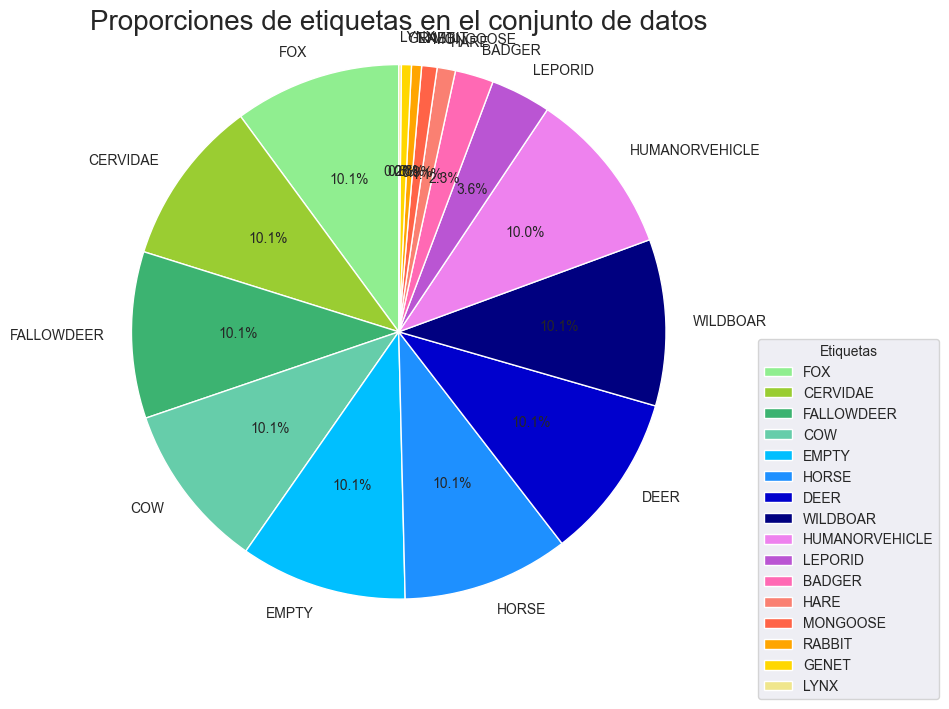

In [153]:
create_graph(df)

Viendo la gráfica, comprobamos que los datos no están balanceados, ya que para algunas etiquetas como:
- LYNX
- GENET
- RABBIT
- MONGOOSE
- HARE
- BADGER
- LEPORID
tenemos un menor número de imágenes si lo comparamos con el número de imágenes que tenemos para las etiquetas:
- HUMANORVEHICLE
- WILDBOAR
- DEER
- EMPTY
- COW
- FALLOWDEER
- CERVIDAE
- FOX

# 3.0 Creación de conjuntos de datos para entrenamiento, validación y test.

Para construir un modelo fiable, es fundamental disponer de 3 conjuntos de datos diferenciados:

* Train: es el conjunto de datos que se utiliza para entrenar y hacer que el modelo aprenda las características o patrones ocultos en los datos. En este proyecto se va a destinar para entrenamiento el 80% del total de imágenes.

* Validation: el conjunto de validación es un conjunto de datos, separado del conjunto de entrenamiento, que se utiliza para validar el rendimiento de nuestro modelo durante el entrenamiento. En este proyecto se va a destinar para entrenamiento el 10% del total de imágenes.

* Test: el conjunto de test es un conjunto separado de datos que se utiliza para probar el modelo después de completar el entrenamiento. En este proyecto se va a destinar para entrenamiento el 10% del total de imágenes.


Además, a la hora de dividir los datos, es necesario que esto se haga de manera estratificada.

Esto se hará creando 3 CSVs diferentes, uno para cada dataset: train, validation, test

Para crear los 3 conjuntos de datos, usamos la función `splitfolders.ratio`, que acepta los siguientes parámetros:

* Ruta donde se encuentran almacenadas las imágenes a dividir.
* Outuput: carpeta donde se crearán los conjuntos de datos.
* Seed: valor inicial para barajar los elementos. Por defecto es 1337.
* Ratio: porcentaje del total de datos destinados a train, validation y test, en este orden.

In [27]:
splitfolders.ratio('/content/Pictures/Solar_Panel_Soiling_Image_dataset/', output="output", seed=1337, ratio=(0.8, 0.1,0.1)) 

Copying files: 45754 files [00:16, 2737.97 files/s]


Una vez que tenemos los datos divididos, vamos a comprobar que se hayan creado 3 conjuntos de datos de manera estratificada. 

Empezamos con los datos de train, aunque previamente vamos a crear un dataframe que contenga los datos de las imágenes destinadas a entrenamiento, haciendo uso de la función que definimos anteriormente para crear dataframes. En este caso, le pasamos la ruta donde están almacenadas las imágenes destinadas a entrenamiento:

In [28]:
# Ruta imágenes
path_imagenes = '/content/output/train/PanelImages'

# Creamos el dataframe
df_train_estratificado = create_dataframe(path = path_imagenes)

# Lo visualizamos
df_train_estratificado

,Image Name,Date,Power Loss,Irradiance
0,solar_Wed_Jun_28_15__5__8_2017_L_0.63868189333...,2017-06-28 15:5:8,63.868,50.994
1,solar_Tue_Jun_13_10__8__23_2017_L_0.0891637528...,2017-06-13 10:8:23,8.916,24.001
2,solar_Tue_Jun_13_13__58__56_2017_L_0.035134835...,2017-06-13 13:58:56,3.513,74.179
3,solar_Tue_Jun_27_12__20__14_2017_L_0.123475315...,2017-06-27 12:20:14,12.348,77.097
4,solar_Sat_Jun_24_12__30__59_2017_L_0.000236671...,2017-06-24 12:30:59,0.024,81.191
...,...,...,...,...
36598,solar_Fri_Jun_16_14__24__15_2017_L_0.408868265...,2017-06-16 14:24:15,40.887,1.521
36599,solar_Wed_Jun_14_14__33__28_2017_L_0.089114790...,2017-06-14 14:33:28,8.911,62.070
36600,solar_Thu_Jun_29_11__37__34_2017_L_0.643142203...,2017-06-29 11:37:34,64.314,51.589
36601,solar_Fri_Jun_23_17__11__22_2017_L_0.291873286...,2017-06-23 17:11:22,29.187,20.166


Vamos a ver la distribución de los datos con ayuda de las gráficas, usando la función que se creó para tal fin. Para ello, pasamos por parámetro el dataframe df_train_estratificado a la función create_dataframe:

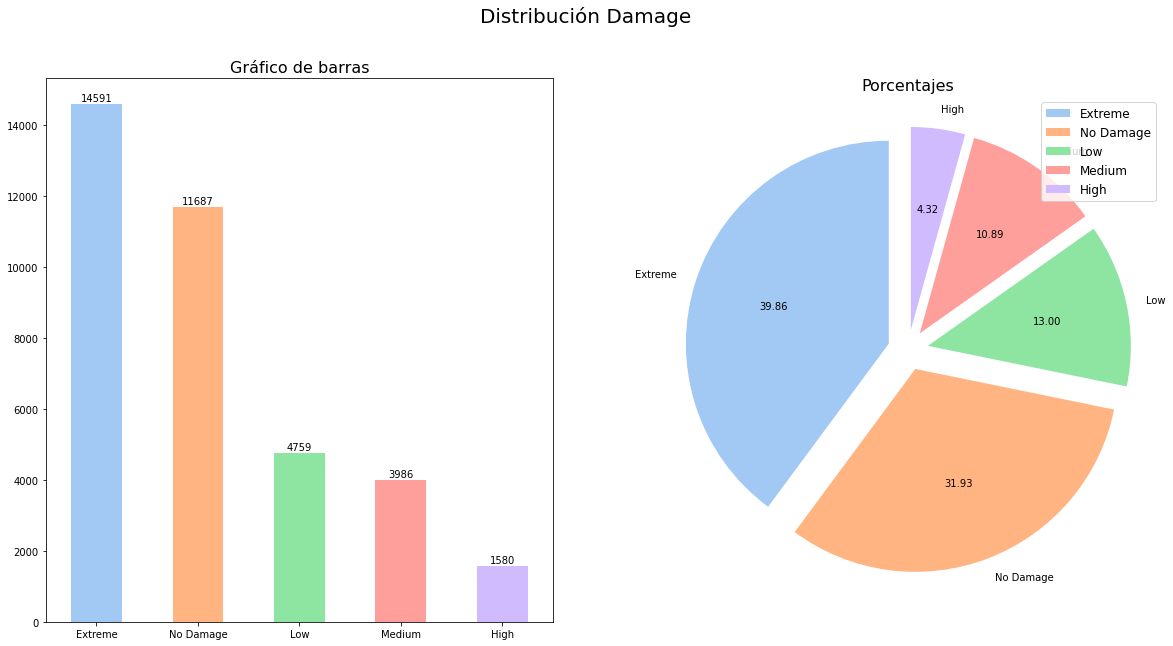

In [29]:
create_graph(df_train_estratificado)

Continuamos con los datos de validación. En este caso, pasamos a la función create_datafreame la ruta donde están almacenadas las imágenes destinadas a validación:

In [30]:
# Ruta imágenes
path_imagenes = '/content/output/val/PanelImages'

# Creamos el dataframe
df_val_estratificado = create_dataframe(path = path_imagenes)

# Lo visualizamos
df_val_estratificado

,Image Name,Date,Power Loss,Irradiance
0,solar_Wed_Jun_28_14__51__46_2017_L_0.633651666...,2017-06-28 14:51:46,63.365,56.750
1,solar_Fri_Jun_30_15__31__2_2017_L_0.5362695661...,2017-06-30 15:31:2,53.627,44.795
2,solar_Wed_Jun_14_10__3__43_2017_L_0.2079107289...,2017-06-14 10:3:43,20.791,73.695
3,solar_Tue_Jun_13_13__25__35_2017_L_0.074575962...,2017-06-13 13:25:35,7.458,30.126
4,solar_Thu_Jun_15_8__45__23_2017_L_0.0853427016...,2017-06-15 8:45:23,8.534,40.074
...,...,...,...,...
4570,solar_Fri_Jun_23_14__12__36_2017_L_0.842175681...,2017-06-23 14:12:36,84.218,14.362
4571,solar_Tue_Jun_13_17__14__42_2017_L_0.104382136...,2017-06-13 17:14:42,10.438,6.560
4572,solar_Fri_Jun_23_7__24__55_2017_L_0.5419713667...,2017-06-23 7:24:55,54.197,11.422
4573,solar_Tue_Jun_20_10__50__32_2017_L_0.122609645...,2017-06-20 10:50:32,12.261,76.861


y vemos la distribución de los datos con ayuda de las gráficas:

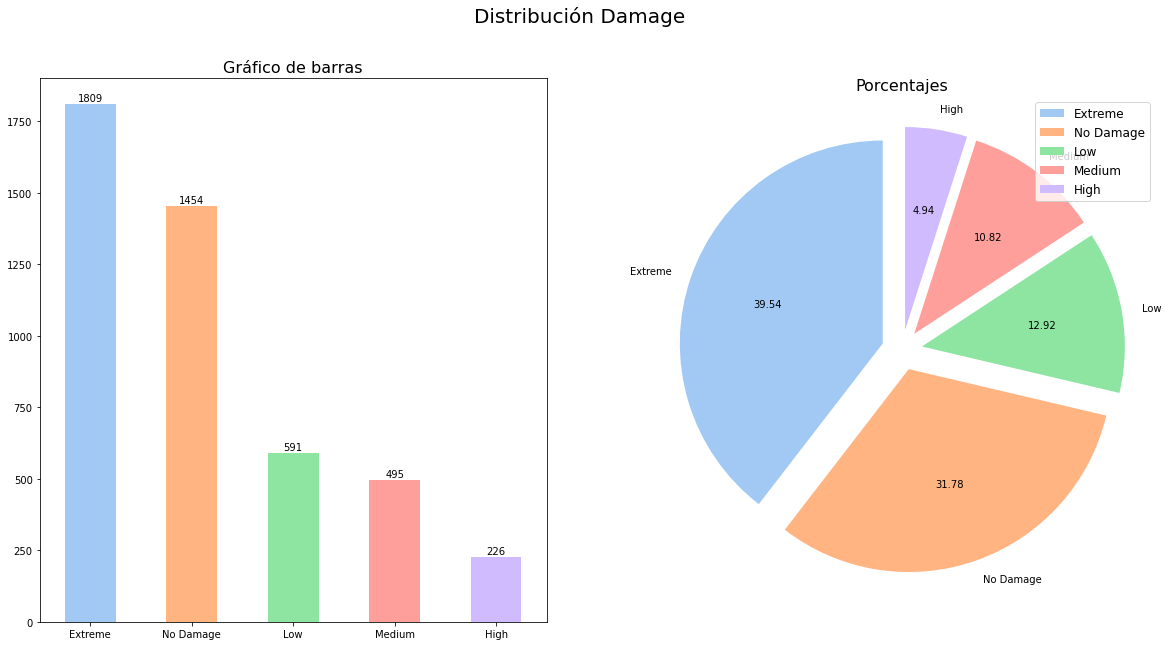

In [31]:
create_graph(df_val_estratificado)

Por último, acabamos con los datos de test:

In [32]:
# Ruta imágenes
path_imagenes = '/content/output/test/PanelImages'

# Creamos el dataframe
df_test_estratificado = create_dataframe(path = path_imagenes)

# Lo visualizamos
df_test_estratificado

,Image Name,Date,Power Loss,Irradiance
0,solar_Sat_Jun_24_12__8__10_2017_L_0.0376098794...,2017-06-24 12:8:10,3.761,29.310
1,solar_Wed_Jun_28_15__39__28_2017_L_0.658349110...,2017-06-28 15:39:28,65.835,24.234
2,solar_Wed_Jun_14_16__19__46_2017_L_0.132167315...,2017-06-14 16:19:46,13.217,35.045
3,solar_Sat_Jun_24_13__49__50_2017_L_0.019513431...,2017-06-24 13:49:50,1.951,24.759
4,solar_Wed_Jun_28_11__45__39_2017_L_0.637964271...,2017-06-28 11:45:39,63.796,39.668
...,...,...,...,...
4571,solar_Fri_Jun_23_17__28__54_2017_L_0.348912830...,2017-06-23 17:28:54,34.891,10.010
4572,solar_Wed_Jun_28_16__52__31_2017_L_0.656709615...,2017-06-28 16:52:31,65.671,18.931
4573,solar_Wed_Jun_21_9__44__2_2017_L_0.78697996241...,2017-06-21 9:44:2,78.698,44.661
4574,solar_Wed_Jun_28_14__58__4_2017_L_0.6654717030...,2017-06-28 14:58:4,66.547,29.755


La distribución de los datos de test es:

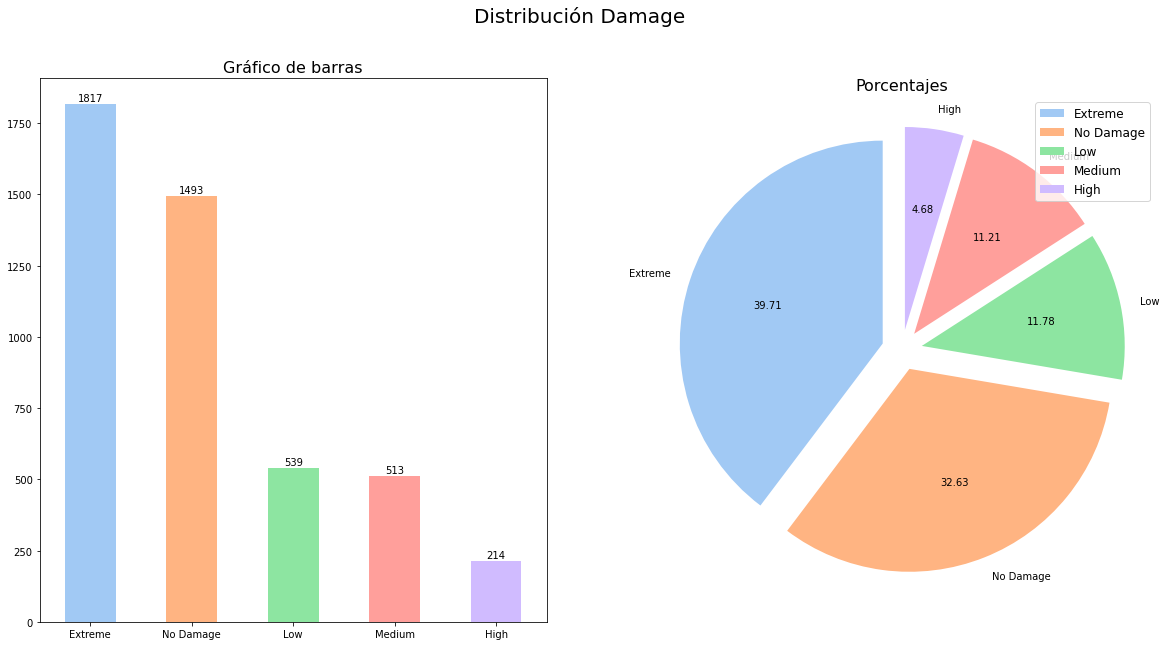

In [33]:
create_graph(df_test_estratificado)

Observando las gráficas, podemos notar que para entrenamiento, validación y test tenemos dividos los datos de manera estratificada, ya que se mantienen las proporciones entre las distintas categorías de nivel de daño.

# 4.0 MODELADO.

En este proyecto vamos a usar dos redes neuronales diferentes. 

La primera, será una red neuronal convolucional no demasiado compleja que vamos a construir con ayuda del siguiente artículo publicado en https://link.springer.com/content/pdf/10.1007/s10489-022-04146-3.pdf, cuyos autores son Diego Marin Santos, Manuel E. Gegundez-Arias, Juan A. Contreras Fernandez, Isaac Perez Borrero y Hector Pallares Manrique.

La segunda red neuronal será la conocida red neuronal convolucional VGG16.

### 4.1 CNN propuesta

La red neuronal propuesta está formada por 6 bloques con estructura similar. En cada bloque se hacen las siguientes operaciones:

* Convolución: se realiza una operación de convolución al tensor de entrada, con un kernel de tamaño 3x3, stride de tamaño 1 y padding de 1.
* Normalización de Batch: se aplica para acelerar y facilitar la convergencia en el entrenamiento.
* ReLU: se aplica a la salida de la normalización del batch.

La única diferencia entre cada bloque radica en el número de capas de convolución incluidas, que progresivamente aumentan de 32 a 96. 

Además, al final de los primeros 5 bloques, se incluye una capa de pooling para reducir el tamaño de datos generados. Para ello, se realiza una operación de MaxPooling de tamañano 3x3, stride de 2 y padding de 1. 

Por el contrario, al final del último bloque, se aplica una operación de GlobalAveragePooling. Además, en este bloque final se añaden dos capas densas, una con 20 neuronas y función de activación relu, y la capa densa final que tendrá una neurona y función de activación relu. Esta última capa está destinada a dar la predicción de pérdida de potencia.

Empezamos creando el modelo:

In [ ]:
model = tf.keras.Sequential(
    [

    # BLOQUE 1  

    tf.keras.layers.Conv2D(input_shape=(192, 192, 3), kernel_size=(3, 3), padding='same', strides = 1, filters = 32),
	  tf.keras.layers.BatchNormalization(),
	  tf.keras.layers.ReLU(),
	  tf.keras.layers.MaxPooling2D(pool_size = (3, 3), padding='same', strides = 2),

    # BLOQUE 2 

    tf.keras.layers.Conv2D(kernel_size=(3, 3), padding='same', strides = 1, filters = 48),
	  tf.keras.layers.BatchNormalization(),
	  tf.keras.layers.ReLU(),
	  tf.keras.layers.MaxPooling2D(pool_size = (3, 3), padding='same', strides = 2),    

    # BLOQUE 3 

    tf.keras.layers.Conv2D(kernel_size=(3, 3), padding='same', strides = 1, filters = 56),
	  tf.keras.layers.BatchNormalization(),
	  tf.keras.layers.ReLU(),
	  tf.keras.layers.MaxPooling2D(pool_size = (3, 3), padding='same', strides = 2), 

    # BLOQUE 4 

    tf.keras.layers.Conv2D(kernel_size=(3, 3), padding='same', strides = 1, filters = 64),
	  tf.keras.layers.BatchNormalization(),
	  tf.keras.layers.ReLU(),
	  tf.keras.layers.MaxPooling2D(pool_size = (3, 3), padding='same', strides = 2), 


    # BLOQUE 5 

    tf.keras.layers.Conv2D(kernel_size=(3, 3), padding='same', strides = 1, filters = 64),
	  tf.keras.layers.BatchNormalization(),
	  tf.keras.layers.ReLU(),
	  tf.keras.layers.MaxPooling2D(pool_size = (3, 3), padding='same', strides = 2),     

    # BLOQUE 6 

    tf.keras.layers.Conv2D(kernel_size=(3, 3), padding='same', strides = 1, filters = 96),
	  tf.keras.layers.BatchNormalization(),
	  tf.keras.layers.ReLU(),
	  tf.keras.layers.GlobalAveragePooling2D(),
		tf.keras.layers.Dense(20,activation='relu'),  
		tf.keras.layers.Dense(1,activation='relu')
    ]
)


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 192, 192, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 192, 192, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 48)        13872     
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 48)       1

Una vez que tenemos el modelo creado, pasamos a definir el código para definir y probar la función de pérdida. Al tratarse de un problema de regresión, elegimos la métrica MeanAbsoluteError. Esta métrica calcula la diferencia media entre los valores calculados y los valores reales.

In [ ]:
loss_fn = tf.keras.losses.MeanAbsoluteError()

A continuación, pasamos a  definir las métricas de evaluación. Como optimizador, vamos a elegir Adam, mientras que para calcular las pérdidas, elegimos la métrica MeanAbsoluteError.

In [ ]:
model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['MeanAbsoluteError']
)

Seguidamente, definimos el hiperparámetro Batch_Size, que define el número de muestras que se propagarán a través de la red. Elegimos un BATCH_SIZE igual a 32.

In [ ]:
BATCH_SIZE = 32

Una vez que tenemos definido el modelo, las métricas de evaluación, la función de pérdidas e hiperparámetro, pasamos a detallar como se alimentará la red con los datos de los que disponemos.
Para tal fin, vamos a usar un generador de imagenes. Esta técnica permite preprocesar los datos de forma personalizada para cada bucle de entrenamiento, como por ejemplo usando técnicas de aumento de datos. Otra ventaja de usar un generador de imágenes es que permite usar gradualmente el conjunto de datos de entrenamiento si su tamaño no permite cargar todo en la RAM.

Definimos un generador de imágenes para el conjunto de datos de train, validation y test. Para ellos, usamos la función de keras `ImageDataGenerator`. En primer lugar, vamos a reescalar los datos. El objetivo de reescalar los datos radica en que nuestras imágenes originales consisten en coeficientes RGB en el rango [0,255], pero tales valores son demasiado altos para que nuestro modelo los procesara, por lo vamos a reescalar para que los valores de los coeficientes RGB estén en el rango [0,1].

Como técnicas de aumento de datos, vamos a aplicar un zoom del 0.1%, vamos a rotar las imágenes 20 grados, y vamos a voltearlas horizontalmente. Esto solo lo vamos a aplicar al generador de imágenes destinadas al entrenamiento de la red.

In [34]:
# Generador datos entrenamiento
train_generator_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    rotation_range = 20,
    horizontal_flip=True,
)

# Generador datos validación
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Generador datos test
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

Además, es necesario definir el directorio donde están las imágenes. Para el caso de las imágenes destinadas a entrenamiento, el directorio será `/content/output/train/PanelImages/`. Para las imágenes destinadas a validación, el directorio será `/content/output/val/PanelImages/`, mientras que para las imágenes destinadas a test, el directorio será `/content/output/test/PanelImages/`.

Por otro lado, como usaremos el generador para alimentar a la red, nos ayudaremos del dataframe creado para especificar el valor de la variable X, que será el nombre de la imagen dentro del directorio, y el valor Y que se pretende predicir, que será la pérdida de potencia de esa imagen en concreto.

In [35]:
# Alimentamos el generador de imágenes con datos de entrenamiento
train_images = train_generator_aug.flow_from_dataframe(
    dataframe=df_train_estratificado,
    directory='/content/output/train/PanelImages/',
    x_col='Image Name',
    y_col='Power Loss',
    target_size=(192, 192),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False,
    seed=42
)

# Alimentamos el generador de imágenes con datos de validación
val_images = val_generator.flow_from_dataframe(
    dataframe=df_val_estratificado,
    directory='/content/output/val/PanelImages/',
    x_col='Image Name',
    y_col='Power Loss',
    target_size=(192, 192),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False,
    seed=42
)

# Alimentamos el generador de imágenes con datos de test
test_images = test_generator.flow_from_dataframe(  
    dataframe=df_test_estratificado,
    directory='/content/output/test/PanelImages/',
    x_col='Image Name',
    y_col='Power Loss',
    class_mode="raw",
    shuffle=False,
    target_size=(192, 192),  # size of the image
    batch_size=1,  # use only one image for visualization
)

Found 36603 validated image filenames.
Found 4575 validated image filenames.
Found 4576 validated image filenames.


Para comprobar el correcto funcionamiento del generador, vamos a graficar 15 imágenes aleatorias del conjunto destinado a entrenamiento, junto con sus valores reales de pérdida de potencia:

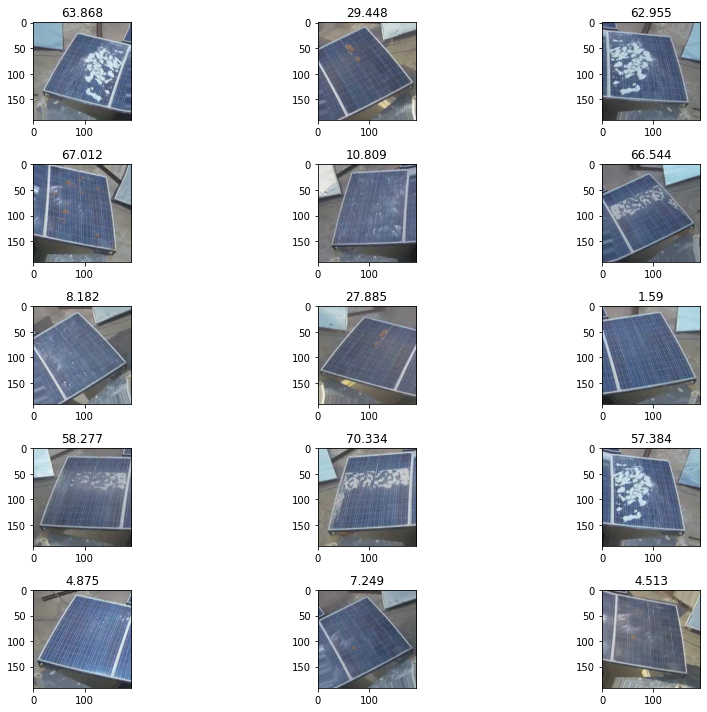

In [36]:
# Número de filas
num_rows = 5

# Número de columnas
num_cols = 3

# Definimos el tamaño de la figura en función del número de columnas y filas
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(15):

    # Creamos la ventana de graficación
    plt.subplot(num_rows, 2*num_cols, 2*i+1)

    # Generamos un batch de imágenes de train. Nos quedamos con la ruta a dicha imagen y el valor de pérdida de potencia
    batch,labels = next(train_images)

    # Graficamos la imagen junto con el valor de pérdida de potencia
    img = batch[0]
    
    # Añadimos el valor de pérdida de potencia como título
    plt.title(labels[0])
    plt.imshow(img)
    
plt.tight_layout()
plt.show()

Una vez comprobado el correcto funcionamiento del generador de imágenes, estamos en disposición de empezar con el entrenamiento. 

El entrenamiento se ha llevado a cabo de la siguiente manera. Debido a las limitaciones de uso de una GPU en versiones gratuitas de colab, no es posible entrenar durante más de 5 horas. Para salvar este impedimento, hemos dividido el entrenamiento en varias fases, de manera que en cada fase hemos usado un número de épocas tal que el tiempo de entrenamiento total no superase las 4 horas. Cuando el modelo había acabado con el entrenamiento en un fase, procedíamos a guardar la red y los valores de pérdidas en un fichero CSV. El objetivo de guardar la red es para poder seguir entrenandola en la siguiente fase de entrenamiento con los pesos que se obtuvieron en la fase, mientras que el objetivo de guardar los valores de pérdidas en el fichero CSV es para poder graficar en una única gráfica dichos valores a lo largo del número total de épocas usadas en el entrenamiento.

Esta metodología se ha usado tanto para la CNN propuesta como para la VGG16.

### 4.1.1 CNN propuesta: entrenamiento fase 1.



Antes de empezar con el entrenamiento, vamos a definir un método llamado Callbacks. Este método de Keras puede ejecutar acciones durante la fase de entrenamiento. Vamos a definir varias acciones en este proyecto.

En primer lugar, definimos una función que nos guardará el modelo que menor valor de pérdida consiga durante el entrenamiento. Para ello, usaremos la librería `ModelCheckPoint` de Keras. Con el uso del parámetro filepath, podemos establecer como queremos que se nombre el modelo guardado.Para una mayor claridad, haremos que el modelo se guarde con la época y el valor de pérdidas.

In [ ]:
# Establecemos el nombre del modelo guardado
filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

# Creamos una instancia de ModelCheckPoint, eligiendo que solo se guarde el mejor modelo
best_model = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

Además, vamos a definir una función que pare el entrenamiento si el modelo no ha mejorado el valor de pérdidas a lo largo de 30 épocas. Para ello, usamos `EarlyStopping`:

In [ ]:
earlystop = EarlyStopping(patience=30)

También, vamos a definir una función que reduzca el valor de learning rate en un factor de 0.5, si el modelo no ha mejorado el valor de pérdidas a lo largo de 10 épocas. Para ello, usamos `ReduceLROnPlateau`:

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='mean_absolute_error', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

Estas 3 funciones componen el método de Callback que se usará durante el entrenamiento. Lo guardamos en la variable callbacks.

In [ ]:
callbacks = [earlystop, best_model, learning_rate_reduction]

Ya podemos empezar a entrenar el modelo. Para ello, usaremos el método .fit() de Keras. Especificamos los datos de entrenamiento, que serán alimentados con el generador de imágenes de entrenamiento, el tamaño del batch, el número de épocas, elegimos que los datos se barajen, le indicamos que se debe usar el método de callback previamente definido y, por último, especificamos las imáganes que se usarán para ir validando como de bien se comporta el modelo con datos nuevos que no han sido usados en el entrenamiento.

Los resultados obtenidos durante el entrenamiento se guardarán en la variable history.

In [ ]:
history_aug = model.fit(train_images, batch_size = BATCH_SIZE ,epochs = 40, shuffle=True, callbacks = callbacks, validation_data=val_images)

Epoch 1/40
1144/1144 [==============================] - ETA: 0s - loss: 8.3326 - mean_absolute_error: 8.3326
Epoch 1: val_loss improved from inf to 5.93234, saving model to my_best_model.epoch01-loss5.93.hdf5
1144/1144 [==============================] - 342s 291ms/step - loss: 8.3326 - mean_absolute_error: 8.3326 - val_loss: 5.9323 - val_mean_absolute_error: 5.9323 - lr: 0.0010
Epoch 2/40
1144/1144 [==============================] - ETA: 0s - loss: 6.2866 - mean_absolute_error: 6.2866
Epoch 2: val_loss did not improve from 5.93234
1144/1144 [==============================] - 337s 294ms/step - loss: 6.2866 - mean_absolute_error: 6.2866 - val_loss: 8.3369 - val_mean_absolute_error: 8.3369 - lr: 0.0010
Epoch 3/40
1144/1144 [==============================] - ETA: 0s - loss: 5.9034 - mean_absolute_error: 5.9034
Epoch 3: val_loss improved from 5.93234 to 5.26694, saving model to my_best_model.epoch03-loss5.27.hdf5
1144/1144 [==============================] - 325s 284ms/step - loss: 5.9034 - 

Hemos acabado con la fase 1 de entrenamiento. Vamos a graficar los resultados de las pérdidas durante entrenamiento y validación.

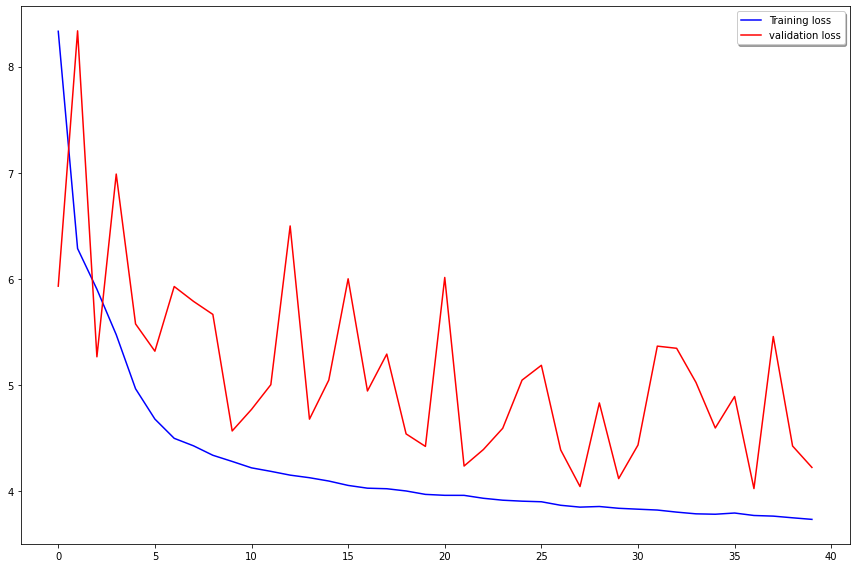

In [ ]:
# Definimos una gráfica de tamaño 12x8
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Graficamos el valor de pérdidas tanto en validación como en entrenamiento. Recordemos que se eligió la métrica MeanAbsoluteError
ax1.plot(history_aug.history['mean_absolute_error'], color='b', label="Training Loss")
ax1.plot(history_aug.history['val_mean_absolute_error'], color='r',label="Validation Loss")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Podemos ver que durante la fase de entrenamiento, el modelo empieza con un valor de pérdidas que se sitúa en torno a 8.5. Con el paso de las épocas, este valor disminuye y al final del entrenamiento se sitúa en torno a 3.7.

Durante la fase de validación, el modelo empieza con un valor de pérdidas que se sitúa en torno a 6. A lo largo del entrenamiento, este valor se va reduciendo y durante las últimas épocas vemos que se sitúa en torno a 4.5. En esta fase de entrenamiento, el mejor modelo se consiguió en la época 37, con un valor de pérdidas de 4.03.

Guardamos estos resultados para no perderlos y poder graficarlo todo en conjunto al final de todas las fases de las que se componga el entrenamiento.

In [ ]:
# Convertimos el diccionario history.history en dataframe   
hist_df = pd.DataFrame(history_aug.history) 

# y lo guardamos en un fichero CSV
hist_csv_file = 'history_aug.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### 4.1.2 CNN propuesta: entrenamiento fase 2.

Empezamos importando el modelo guardado durante la fase anterior.

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/TFM/my_best_model.epoch37-loss4.03.hdf5")

Seguimos entrenando el modelo durante 40 épocas más. Las métricas de evaluación, función de pérdidas y método de callback no hace falta volverlos a definir, puesto que se usarán los mismos que se usaron en la fase anterior.

In [ ]:
history_aug = model.fit(train_images, batch_size = BATCH_SIZE ,epochs = 40, shuffle=True, callbacks = callbacks, validation_data=val_images)

Epoch 1/40
1144/1144 [==============================] - ETA: 0s - loss: 3.7716 - mean_absolute_error: 3.7716
Epoch 1: val_loss improved from inf to 4.53981, saving model to my_best_model.epoch01-loss4.54.hdf5
1144/1144 [==============================] - 341s 288ms/step - loss: 3.7716 - mean_absolute_error: 3.7716 - val_loss: 4.5398 - val_mean_absolute_error: 4.5398 - lr: 0.0010
Epoch 2/40
1144/1144 [==============================] - ETA: 0s - loss: 3.7627 - mean_absolute_error: 3.7627
Epoch 2: val_loss improved from 4.53981 to 4.12225, saving model to my_best_model.epoch02-loss4.12.hdf5
1144/1144 [==============================] - 321s 280ms/step - loss: 3.7627 - mean_absolute_error: 3.7627 - val_loss: 4.1222 - val_mean_absolute_error: 4.1222 - lr: 0.0010
Epoch 3/40
1144/1144 [==============================] - ETA: 0s - loss: 3.7477 - mean_absolute_error: 3.7477
Epoch 3: val_loss improved from 4.12225 to 4.07109, saving model to my_best_model.epoch03-loss4.07.hdf5
1144/1144 [==========

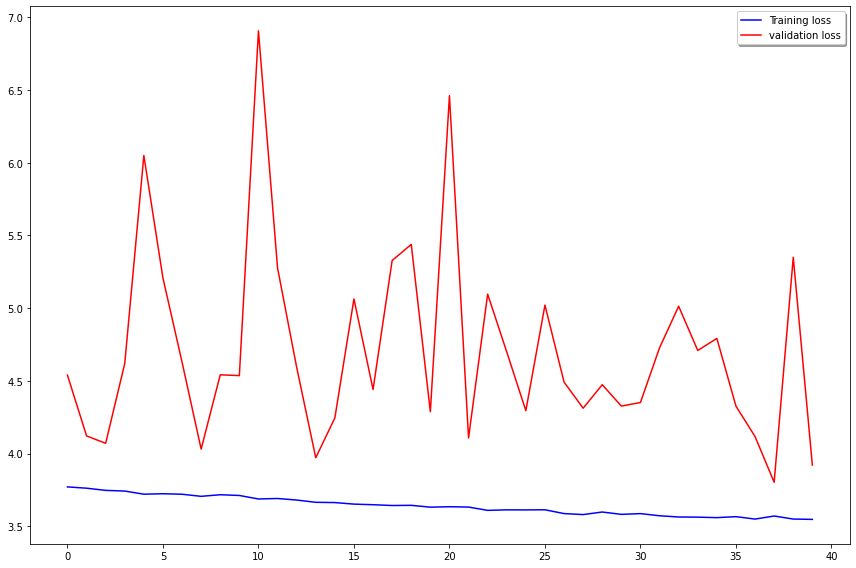

In [ ]:
# Definimos una gráfica de tamaño 12x8
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Graficamos el valor de pérdidas tanto en validación como en entrenamiento. Recordemos que se eligió la métrica MeanAbsoluteError
ax1.plot(history_aug.history['mean_absolute_error'], color='b', label="Training Loss")
ax1.plot(history_aug.history['val_mean_absolute_error'], color='r',label="Validation Loss")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Podemos ver que durante la fase de entrenamiento, el modelo empieza con un valor de pérdidas que se sitúa en torno a 3.7. Con el paso de las épocas, este valor disminuye, aunque con menor ritmo, y al final del entrenamiento se sitúa en torno a 3.5.

Durante la fase de validación, el modelo empieza con un valor de pérdidas que se sitúa en torno a 4.5. A lo largo del entrenamiento, este valor se va reduciendo y durante las últimas épocas vemos que se sitúa en torno a 4. En esta fase de entrenamiento, el mejor modelo se consiguió en la época 38, con un valor de pérdidas de 3.8.

Guardamos estos resultados para no perderlos y poder graficarlo todo en conjunto al final de todas las fases de las que se componga el entrenamiento.

In [ ]:
# Convertimos el diccionario history.history en dataframe   
hist_df = pd.DataFrame(history_aug.history) 

# y lo guardamos en un fichero CSV
hist_csv_file = 'history_aug.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### 4.1.3 CNN propuesta: entrenamiento fase 3.

Empezamos importando el modelo guardado durante la fase anterior.

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/TFM/my_best_model.epoch38-loss3.80.hdf5")

Seguimos entrenando el modelo durante 40 épocas más. Las métricas de evaluación, función de pérdidas y método de callback no hace falta volverlos a definir, puesto que se usarán los mismos que se usaron en la fase anterior.

In [ ]:
history_aug = model.fit(train_images, batch_size = BATCH_SIZE ,epochs = 40, shuffle=True, callbacks = callbacks, validation_data=val_images)

Epoch 1/40
1144/1144 [==============================] - ETA: 0s - loss: 3.5980 - mean_absolute_error: 3.5980
Epoch 1: val_loss improved from inf to 4.06850, saving model to my_best_model.epoch01-loss4.07.hdf5
1144/1144 [==============================] - 340s 289ms/step - loss: 3.5980 - mean_absolute_error: 3.5980 - val_loss: 4.0685 - val_mean_absolute_error: 4.0685 - lr: 0.0010
Epoch 2/40
1144/1144 [==============================] - ETA: 0s - loss: 3.5756 - mean_absolute_error: 3.5756
Epoch 2: val_loss did not improve from 4.06850
1144/1144 [==============================] - 330s 289ms/step - loss: 3.5756 - mean_absolute_error: 3.5756 - val_loss: 4.9817 - val_mean_absolute_error: 4.9817 - lr: 0.0010
Epoch 3/40
1144/1144 [==============================] - ETA: 0s - loss: 3.5727 - mean_absolute_error: 3.5727
Epoch 3: val_loss did not improve from 4.06850
1144/1144 [==============================] - 333s 291ms/step - loss: 3.5727 - mean_absolute_error: 3.5727 - val_loss: 4.8809 - val_mean

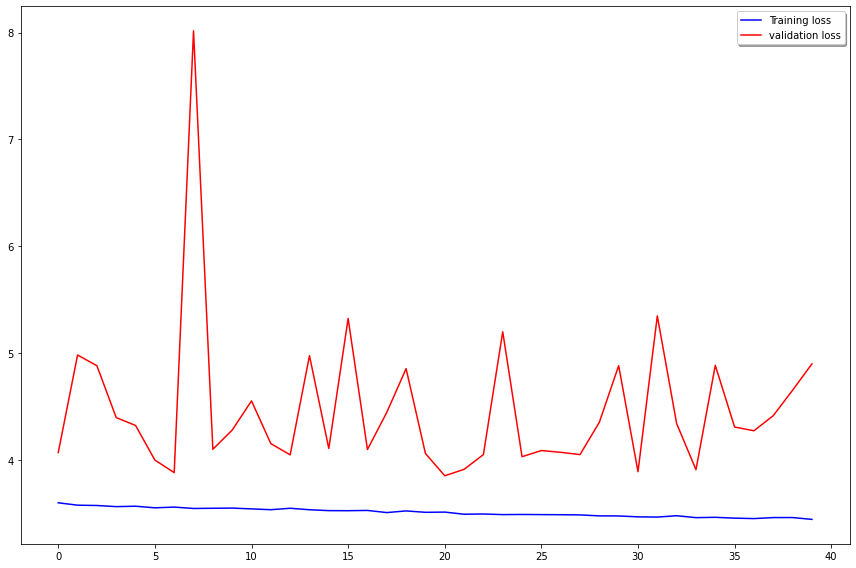

In [ ]:
# Definimos una gráfica de tamaño 12x8
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Graficamos el valor de pérdidas tanto en validación como en entrenamiento. Recordemos que se eligió la métrica MeanAbsoluteError
ax1.plot(history_aug.history['mean_absolute_error'], color='b', label="Training Loss")
ax1.plot(history_aug.history['val_mean_absolute_error'], color='r',label="Validation Loss")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Podemos ver que durante la fase de entrenamiento, el modelo empieza con un valor de pérdidas que se sitúa en torno a 3.5. Con el paso de las épocas, este valor disminuye y al final del entrenamiento se sitúa en torno a 3.44. Comprobamos que, con el paso de las épocas, el modelo va aprendiendo cada vez más lentamente.

Durante la fase de validación, el modelo empieza con unos valores de pérdidas que se sitúa en torno a 4. A lo largo del entrenamiento, este valor apenas disminuye, y vemos que el valor de pérdidas oscila entre 3.9 y 5. En esta fase de entrenamiento, el mejor modelo se consiguió en la época 21, con un valor de pérdidas de 3.85.

Guardamos estos resultados para no perderlos y poder graficarlo todo en conjunto al final de todas las fases de las que se componga el entrenamiento.

In [ ]:
# Convertimos el diccionario history.history en dataframe   
hist_df = pd.DataFrame(history_aug.history) 

# y lo guardamos en un fichero CSV
hist_csv_file = 'history_aug.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### 4.1.4 CNN propuesta: entrenamiento fase 4.

Empezamos importando el modelo guardado durante la fase anterior.

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/TFM/my_best_model.epoch01-loss3.86.hdf5")

Seguimos entrenando el modelo durante 40 épocas más. Las métricas de evaluación, función de pérdidas y método de callback no hace falta volverlos a definir, puesto que se usarán los mismos que se usaron en la fase anterior.

In [ ]:
history_aug = model.fit(train_images, batch_size = BATCH_SIZE ,epochs = 40, shuffle=True, callbacks = callbacks, validation_data=val_images)

Epoch 1/40
1144/1144 [==============================] - ETA: 0s - loss: 3.4891 - mean_absolute_error: 3.4891
Epoch 1: val_loss improved from inf to 3.85797, saving model to my_best_model.epoch01-loss3.86.hdf5
1144/1144 [==============================] - 325s 276ms/step - loss: 3.4891 - mean_absolute_error: 3.4891 - val_loss: 3.8580 - val_mean_absolute_error: 3.8580 - lr: 0.0010
Epoch 2/40
1144/1144 [==============================] - ETA: 0s - loss: 3.4766 - mean_absolute_error: 3.4766
Epoch 2: val_loss did not improve from 3.85797
1144/1144 [==============================] - 314s 274ms/step - loss: 3.4766 - mean_absolute_error: 3.4766 - val_loss: 4.2419 - val_mean_absolute_error: 4.2419 - lr: 0.0010
Epoch 3/40
1144/1144 [==============================] - ETA: 0s - loss: 3.4729 - mean_absolute_error: 3.4729
Epoch 3: val_loss did not improve from 3.85797
1144/1144 [==============================] - 312s 273ms/step - loss: 3.4729 - mean_absolute_error: 3.4729 - val_loss: 4.6124 - val_mean

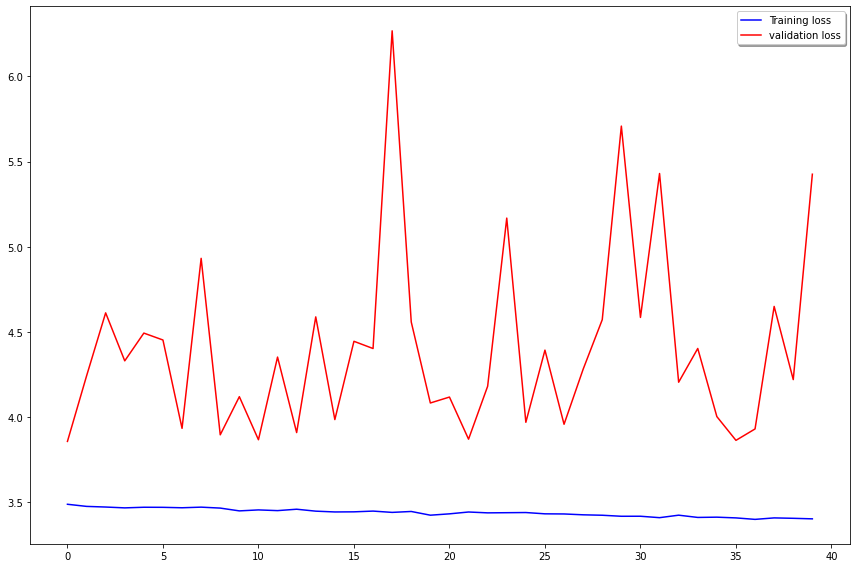

In [ ]:
# Definimos una gráfica de tamaño 12x8
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Graficamos el valor de pérdidas tanto en validación como en entrenamiento. Recordemos que se eligió la métrica MeanAbsoluteError
ax1.plot(history_aug.history['mean_absolute_error'], color='b', label="Training Loss")
ax1.plot(history_aug.history['val_mean_absolute_error'], color='r',label="Validation Loss")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Podemos ver que durante la fase de entrenamiento, el modelo empieza con un valor de pérdidas que se sitúa en torno a 3.48. Con el paso de las épocas, este valor apenas disminuye, y al final del entrenamiento se sitúa en torno a 3.4.

Durante la validación, el modelo empieza con un valor de pérdidas que se sitúa en torno a 3.85. No se aprecia mejoría a lo largo de épocas y puede verse que el valor de pérdidas cada vez es mayor. En esta fase de entrenamiento, el mejor modelo se consiguió en la época 1, con un valor de pérdidas de 3.85.

Por lo tanto, parece que el modelo no es capaz de extraer más información de los datos.

Guardamos estos resultados para no perderlos y poder graficarlo todo en conjunto al final de todas las fases de las que se componga el entrenamiento.

In [ ]:
# Convertimos el diccionario history.history en dataframe   
hist_df = pd.DataFrame(history_aug.history) 

# y lo guardamos en un fichero CSV
hist_csv_file = 'history_aug.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### 4.1.5 CNN propuesta: análisis de resultados.

Una vez acabado el entrenamiento del primer modelo, vamos a graficar los resultados obtenidos durante las 240 épocas que ha durado el entrenamiento.

Importamos los CSV guardados:

In [ ]:
history1 = pd.read_csv("/content/drive/MyDrive/TFM/history1.csv")
history2 = pd.read_csv("/content/drive/MyDrive/TFM/history2.csv")
history3 = pd.read_csv("/content/drive/MyDrive/TFM/history3.csv")
history4 = pd.read_csv("/content/drive/MyDrive/TFM/history4.csv")

Agrupamos los resultados en un único dataframe:Y graficamos los valores de pérdidas:

In [ ]:
final_dataframe = pd.concat([history1, history2, history3, history4]).reset_index(drop=True) 

Y graficamos los valores de pérdidas:

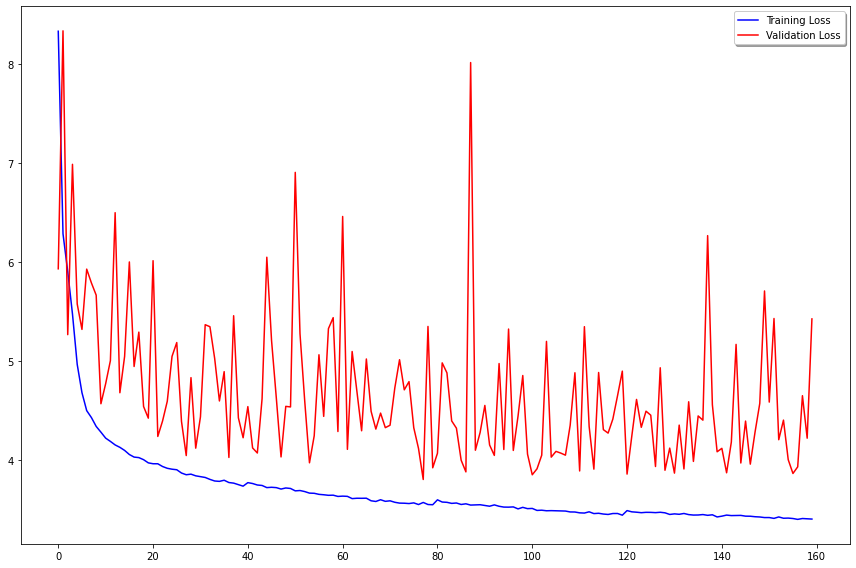

In [ ]:
# Definimos una gráfica de tamaño 12x8
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Graficamos el valor de pérdidas tanto en validación como en entrenamiento
ax1.plot(final_dataframe['mean_absolute_error'], color='b', label="Training Loss")
ax1.plot(final_dataframe['val_mean_absolute_error'], color='r',label="Validation Loss")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Observando la curva de pérdidas durante la etapa de validación, vemos que durante las distintas épocas el valor de pérdida mayoritariamente oscila entre 3.7 y 4.5, aproximadamente. Esto nos hace pensar que el modelo no va a mejorar en validación aunque sigamos entrenando durante mas épocas. Por otra parte, vemos que el valor de pérdidas durante la etapa de entrenamiento va disminuyendo durante el paso de las épocas, por que lo parece que el modelo está sobreaprendiendo los datos de entrenamiento.



Vamos a pasar a evaluar el modelo y a hacer predicciones sobre los datos de test. Para ello, importamos el modelo que menor valor de pérdias ha conseguido. Recordemos que el mejor modelo se consiguió en la fase 2 de entrenamiento, con un valor de pérdidas en validación de 3.8.

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/TFM/my_best_model.epoch38-loss3.80.hdf5")

Evaluamos:

In [ ]:
model.evaluate(test_images)

4576/4576 [==============================] - 28s 5ms/step - loss: 3.8280 - mean_absolute_error: 3.8280


[3.827977418899536, 3.827977418899536]

Hacemos predicciones:

In [ ]:
predictions = model.predict(test_images)

4576/4576 [==============================] - 18s 4ms/step


Las guardamos en un dataframe:

In [ ]:
df_predictions = pd.DataFrame(data = predictions, columns = ['Predictions'])

Y graficamos 15 imágenes aleatorias junto con los valores de pérdida de potencia predichos y los valores de pérdida de potencia reales:

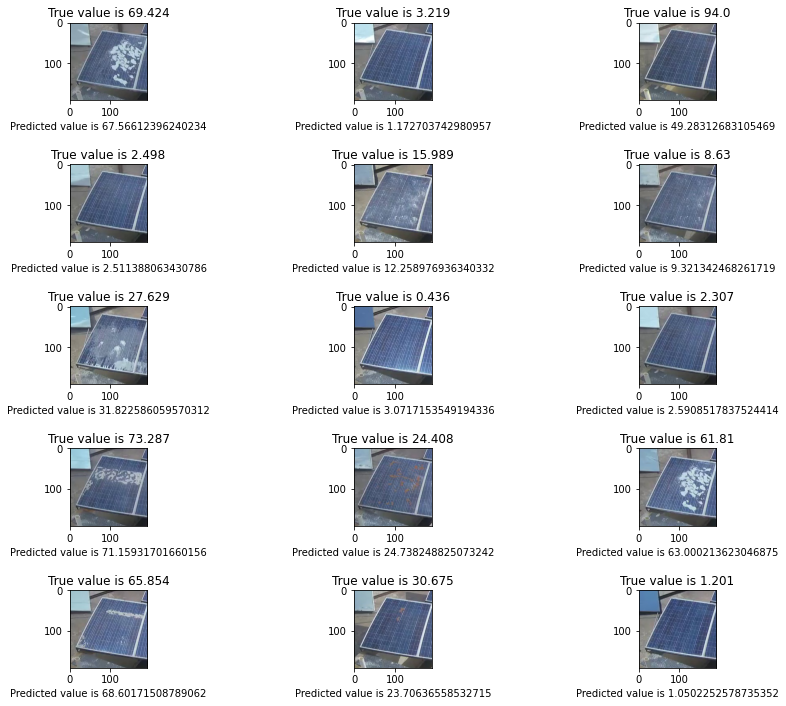

In [ ]:
# Número de filas
num_rows = 5

# Número de columnas
num_cols = 3

len(df_test_estratificado)

num_images = num_rows*num_cols
# Definimos el tamaño de la figura en función del número de columnas y filas
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):

  # Creamos la ventana de graficación
  plt.subplot(num_rows, 2*num_cols, 2*i+1)

  # Elegimos una imagen aleatoria
  sample = random.choice(range(len(df_test_estratificado)))
  
  # Graficamos la imagen elegida
  image = plt.imread('/content/output/test/PanelImages/' + df_test_estratificado['Image Name'][sample])
  plt.imshow(image, cmap=plt.cm.binary)

  # Añadimos el valor real y la predicción de pérdida de potencia
  plt.title('True value is {}'.format(df_test_estratificado['Power Loss'][sample]))
  plt.xlabel('Predicted value is {}'.format(df_predictions['Predictions'][sample]))

plt.tight_layout()
plt.show()

Analizando las predicciones vemos que, para gran parte de las imágenes, el valor predicho es cercano al valor real. Solo encontramos algunos casos en los que el valor predicho se aleja en gran medida del valor real.

Por último, vamos a comprobar como se comporta el modelo con imágenes de paneles solares diferentes a las usadas hasta ahora.

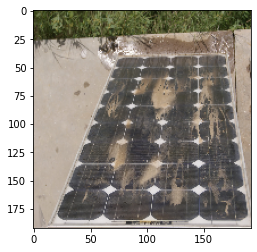

In [ ]:
# Leemos la imagen
img = cv2.imread('/content/1.jpg')

# Convertimos la imagen a RGB ya que por defecto CV2 lee en formato BGR
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionamos al tamaño de imagen que la red necesita
dsize = (192, 192)
output = cv2.resize(RGB_img, dsize)

# Normalizamos la imagen para que los coeficientes RGB estén en el rango [0,1]
norm_image = cv2.normalize(output, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Graficamos la imagen
plt.imshow(norm_image)

In [ ]:
# Añadimos la dimensión perteneciente al Batch ya que hay que respetar el formato que espera la red
img = np.expand_dims(norm_image, axis=0)

# Hacemos la predicción
model.predict(img)

1/1 [==============================] - 0s 136ms/step


array([[13.81716]], dtype=float32)

Vemos que la red da una predicción de pérdida de potencia del 13.81%. Desconocemos el valor real de pérdida de potencia de este panel de la imagen, por lo que no podemos saber si el valor de predicción que nos ha dado nuestro se aleja de la realidad. Aun así, vemos que la red da un valor coherente, puesto que en la imagen se aprecia suciedad, lo que provocaría una pérdida de potencia.

Comprobamos con otra imagen.

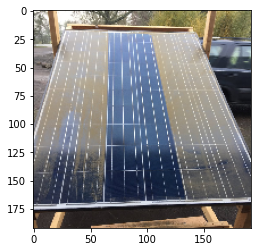

In [ ]:
# Leemos la imagen
img = cv2.imread('/content/2.jpeg')

# Convertimos la imagen a RGB ya que por defecto CV2 lee en formato BGR
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionamos al tamaño de imagen que la red necesita
dsize = (192, 192)
output = cv2.resize(RGB_img, dsize)

# Normalizamos la imagen para que los coeficientes RGB estén en el rango [0,1]
norm_image = cv2.normalize(output, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Graficamos la imagen
plt.imshow(norm_image)

In [ ]:
# Añadimos la dimensión perteneciente al Batch ya que hay que respetar el formato que espera la red
img = np.expand_dims(norm_image, axis=0)

# Hacemos la predicción
model.predict(img)

1/1 [==============================] - 0s 28ms/step


array([[19.932295]], dtype=float32)

Nuevamente, desconocemos el valor real de pérdida de potencia de este panel de la imagen. Vemos que la red da una predicción de pérdida de potencia del 52.26%.No podemos saber si el valor de predicción que nos ha dado nuestro se aleja de la realidad. Aun así, vemos que la red da un valor coherente, puesto que en la imagen se aprecia suciedad, lo que provocaría una pérdida de potencia.

Por último, vamos a introducir una imagen de un panel que, aparentemente, no deberia presentar pérdida de potencia debido a suciedad presente en el panel.

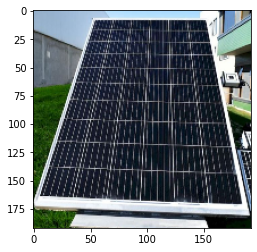

In [ ]:
# Leemos la imagen
img = cv2.imread('/content/5.JPG')

# Convertimos la imagen a RGB ya que por defecto CV2 lee en formato BGR
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionamos al tamaño de imagen que la red necesita
dsize = (192, 192)
output = cv2.resize(RGB_img, dsize)

# Normalizamos la imagen para que los coeficientes RGB estén en el rango [0,1]
norm_image = cv2.normalize(output, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Graficamos la imagen
plt.imshow(norm_image)

In [ ]:
# Añadimos la dimensión perteneciente al Batch ya que hay que respetar el formato que espera la red
img = np.expand_dims(norm_image, axis=0)

# Hacemos la predicción
model.predict(img)

1/1 [==============================] - 0s 17ms/step


array([[32.536526]], dtype=float32)

### 4.2 VGG16 - Transfer Learning

La siguiente red neuronal convolucional que se va a usar en nuestro proyecto es la conocida VGG16. Es una red con arquitectura simple y, en cierto modo, parecida a nuestra red neuronal convolucional propuesta.

La VGG16 está formada por bloques compuestos por un número incremental de capas convolucionales con filtros de tamaño 3×3. Además, se añaden capas de maxpooling entre las capas convolucionales para reducir el tamaño de los datos generados. Finalmente, se utiliza un bloque de clasificación compuesto por dos capas densas de 4096 neuronas cada una, y una última capa, que es la de salida, de 1000 neuronas.

En nuestro proyecto, vamos a usar la técnica de transfer learning con este modelo, usando los pesos imagenet, sin incluir la capa final, ya que necesitamos adaptar la red a nuestro problema. Esto se hace para recuperar los pesos de las capas de convolución y entrenar las últimas capas que añadimos.


Empezamos importando el modelo:

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

Seguidamente, vamos a leer el modelo VGG16. Cargamos los pesos imagenet, especificamos el tamaño de imagen con la que se va a alimentar la red y especificamos que no se incluya la capa final usada para hacer predicciones. Esto es necesario para adaptar la red a un problema de regresión y, también, para adaptar los pesos de la capa final a nuestros datos.

In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(192, 192, 3))

Congelamos todos los pesos para que no se modifiquen durante el entrenamiento:

In [ ]:
base_model.trainable = False

Construimos el bloque final, añadiendo una capa densa de 20 neuronas con función de activación relu, y una capa final densa de 1 neurona con función de activación relu, usada para hacer la predicción.

In [ ]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(1, activation='relu')

Creamos el modelo:

In [ ]:
model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    prediction_layer
])

Una vez que tenemos el modelo creado, pasamos a definir el código para definir y probar la función de pérdida. Al tratarse de un problema de regresión, elegimos la métrica MeanAbsoluteError. Esta métrica calcula la diferencia media entre los valores calculados y los valores reales.


In [ ]:
loss_fn = tf.keras.losses.MeanAbsoluteError()

A continuación, pasamos a  definir las métricas de evaluación. Como optimizador, vamos a elegir Adam, mientras que para calcular las pérdidas, elegimos la métrica MeanAbsoluteError.


In [ ]:
model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['MeanAbsoluteError']
)

Seguidamente, definimos el hiperparámetro Batch_Size, que define el número de muestras que se propagarán a través de la red. Elegimos un BATCH_SIZE igual a 32.

In [ ]:
BATCH_SIZE = 32

Para este modelo. también se usará el mismo generador de imágenes que el usado para el modelo anterior, por lo que no hará falta volver a definirlos.

### 4.2.1 VGG16: entrenamiento fase 1.

Vamos a definir el mismo método de callback que el usado para el modelo anterior.

En primer lugar, definimos una función que nos guardará el modelo que menor valor de pérdida consiga durante el entrenamiento. Para ello, usaremos la librería `ModelCheckPoint` de Keras. Con el uso del parámetro filepath, podemos establecer como queremos que se nombre el modelo guardado.Para una mayor claridad, haremos que el modelo se guarde con la época y el valor de pérdidas.

In [ ]:
# Establecemos el nombre del modelo guardado
filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

# Creamos una instancia de ModelCheckPoint, eligiendo que solo se guarde el mejor modelo
best_model = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

Además, vamos a definir una función que pare el entrenamiento si el modelo no ha mejorado el valor de pérdidas a lo largo de 30 épocas. Para ello, usamos `EarlyStopping`:


In [ ]:
earlystop = EarlyStopping(patience=30)

También, vamos a definir una función que reduzca el valor de learning rate en un factor de 0.5, si el modelo no ha mejorado el valor de pérdidas a lo largo de 10 épocas. Para ello, usamos `ReduceLROnPlateau`:


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='mean_absolute_error', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

Estas 3 funciones componen el método de Callback que se usará durante el entrenamiento. Lo guardamos en la variable `callbacks`.

In [ ]:
callbacks = [earlystop, best_model, learning_rate_reduction]

Ya podemos empezar a entrenar el modelo. Para ello, usaremos el método .fit() de Keras. Especificamos los datos de entrenamiento, que serán alimentados con el generador de imágenes de entrenamiento, el tamaño del batch, el número de épocas, elegimos que los datos se barajen, le indicamos que se debe usar el método de callback previamente definido y, por último, especificamos las imáganes que se usarán para ir validando como de bien se comporta el modelo con datos nuevos que no han sido usados en el entrenamiento.

Los resultados obtenidos durante el entrenamiento se guardarán en la variable history_aug.

In [ ]:
history_aug = model.fit(train_images, batch_size = BATCH_SIZE ,epochs = 40, shuffle=True, callbacks = callbacks, validation_data=val_images)

Epoch 1/40
1144/1144 [==============================] - ETA: 0s - loss: 10.5082 - mean_absolute_error: 10.5082
Epoch 1: val_loss improved from inf to 7.46990, saving model to my_best_model.epoch01-loss7.47.hdf5
1144/1144 [==============================] - 362s 315ms/step - loss: 10.5082 - mean_absolute_error: 10.5082 - val_loss: 7.4699 - val_mean_absolute_error: 7.4699 - lr: 0.0010
Epoch 2/40
1144/1144 [==============================] - ETA: 0s - loss: 7.2563 - mean_absolute_error: 7.2563
Epoch 2: val_loss improved from 7.46990 to 6.59454, saving model to my_best_model.epoch02-loss6.59.hdf5
1144/1144 [==============================] - 356s 311ms/step - loss: 7.2563 - mean_absolute_error: 7.2563 - val_loss: 6.5945 - val_mean_absolute_error: 6.5945 - lr: 0.0010
Epoch 3/40
1144/1144 [==============================] - ETA: 0s - loss: 6.6285 - mean_absolute_error: 6.6285
Epoch 3: val_loss improved from 6.59454 to 6.34475, saving model to my_best_model.epoch03-loss6.34.hdf5
1144/1144 [======

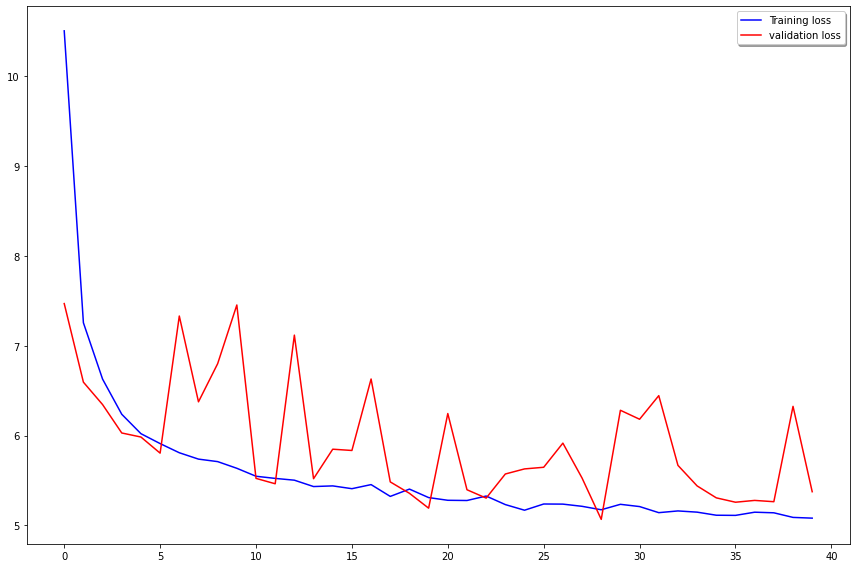

In [ ]:
# Definimos una gráfica de tamaño 12x8
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Graficamos el valor de pérdidas tanto en validación como en entrenamiento. Recordemos que se eligió la métrica MeanAbsoluteError
ax1.plot(history_aug.history['mean_absolute_error'], color='b', label="Training Loss")
ax1.plot(history_aug.history['val_mean_absolute_error'], color='r',label="Validation Loss")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Podemos ver que durante la fase de entrenamiento, el modelo empieza con un valor de pérdidas que se sitúa en torno a 11. Con el paso de las épocas, este valor va disminuyendo, y al final del entrenamiento se sitúa en torno a 5.

Durante la validación, el modelo empieza con un valor de pérdidas que se sitúa en torno a 7.5. Con el paso de las épocas, este valor va disminuyendo y, al final del entrenamiento, se sitúa en torno a 5.6. En esta fase de entrenamiento, el mejor modelo se consiguió en la época 29, con un valor de pérdidas de 5.07.

Guardamos estos resultados para no perderlos y poder graficarlo todo en conjunto al final de todas las fases de las que se componga el entrenamiento.


In [ ]:
# Convertimos el diccionario history.history en dataframe   
hist_df = pd.DataFrame(history_aug.history) 

# y lo guardamos en un fichero CSV
hist_csv_file = 'history_aug.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### 4.2.2 VGG16: entrenamiento fase 2.


Empezamos importando el modelo guardado en la fase anterior:

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/TFM/my_best_model.epoch29-loss5.07.hdf5")

Seguimos entrenando el modelo durante 40 épocas más. Las métricas de evaluación, función de pérdidas y método de callback no hace falta volverlos a definir, puesto que se usarán los mismos que se usaron en la fase anterior.

In [ ]:
history_aug = model.fit(train_images, batch_size = BATCH_SIZE ,epochs = 40, shuffle=True, callbacks = callbacks, validation_data=val_images)

Epoch 1/40
1144/1144 [==============================] - ETA: 0s - loss: 5.1945 - mean_absolute_error: 5.1945
Epoch 1: val_loss improved from inf to 5.69281, saving model to my_best_model.epoch01-loss5.69.hdf5
1144/1144 [==============================] - 386s 328ms/step - loss: 5.1945 - mean_absolute_error: 5.1945 - val_loss: 5.6928 - val_mean_absolute_error: 5.6928 - lr: 0.0010
Epoch 2/40
1144/1144 [==============================] - ETA: 0s - loss: 5.1432 - mean_absolute_error: 5.1432
Epoch 2: val_loss improved from 5.69281 to 5.38292, saving model to my_best_model.epoch02-loss5.38.hdf5
1144/1144 [==============================] - 370s 323ms/step - loss: 5.1432 - mean_absolute_error: 5.1432 - val_loss: 5.3829 - val_mean_absolute_error: 5.3829 - lr: 0.0010
Epoch 3/40
1144/1144 [==============================] - ETA: 0s - loss: 5.1674 - mean_absolute_error: 5.1674
Epoch 3: val_loss improved from 5.38292 to 5.23198, saving model to my_best_model.epoch03-loss5.23.hdf5
1144/1144 [==========

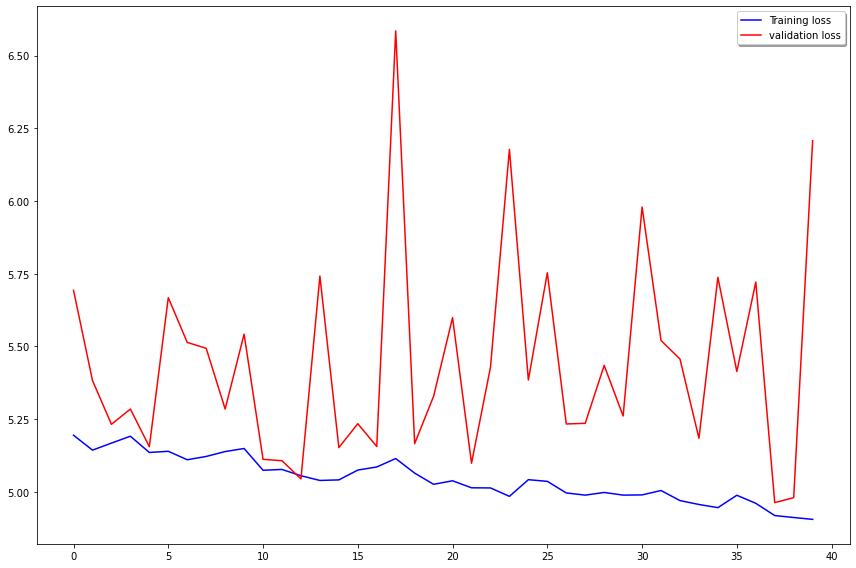

In [ ]:
# Definimos una gráfica de tamaño 12x8
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Graficamos el valor de pérdidas tanto en validación como en entrenamiento. Recordemos que se eligió la métrica MeanAbsoluteError
ax1.plot(history_aug.history['mean_absolute_error'], color='b', label="Training Loss")
ax1.plot(history_aug.history['val_mean_absolute_error'], color='r',label="Validation Loss")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Podemos ver que durante la fase entrenamiento, el modelo empieza con un valor de pérdidas que se sitúa en torno a 5.2. Con el paso de las épocas, este valor va disminuyendo, y al final del entrenamiento se sitúa en torno a 4.9.

Durante la validación, el modelo empieza con un valor de pérdidas que se sitúa en torno a 5.75. Con el paso de las épocas, vemos que el modelo va aprendiendo. En esta fase de entrenamiento, el mejor modelo se consiguió en la época 38, con un valor de pérdidas de 4.96.

Guardamos estos resultados para no perderlos y poder graficarlo todo en conjunto al final de todas las fases de las que se componga el entrenamiento.


In [ ]:
# Convertimos el diccionario history.history en dataframe   
hist_df = pd.DataFrame(history_aug.history) 

# y lo guardamos en un fichero CSV
hist_csv_file = 'history_aug.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### 4.2.3 VGG16: entrenamiento fase 3.

Empezamos importando el modelo guardado en la fase anterior:

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/TFM/my_best_model.epoch38-loss4.96.hdf5")

Seguimos entrenando el modelo durante 40 épocas más. Las métricas de evaluación, función de pérdidas y método de callback no hace falta volverlos a definir, puesto que se usarán los mismos que se usaron en la fase anterior.

In [ ]:
history_aug = model.fit(train_images, batch_size = BATCH_SIZE ,epochs = 40, shuffle=True, callbacks = callbacks, validation_data=val_images)

Epoch 1/40
1144/1144 [==============================] - ETA: 0s - loss: 4.9552 - mean_absolute_error: 4.9552
Epoch 1: val_loss improved from inf to 5.58139, saving model to my_best_model.epoch01-loss5.58.hdf5
1144/1144 [==============================] - 383s 326ms/step - loss: 4.9552 - mean_absolute_error: 4.9552 - val_loss: 5.5814 - val_mean_absolute_error: 5.5814 - lr: 0.0010
Epoch 2/40
1144/1144 [==============================] - ETA: 0s - loss: 4.9273 - mean_absolute_error: 4.9273
Epoch 2: val_loss improved from 5.58139 to 5.28066, saving model to my_best_model.epoch02-loss5.28.hdf5
1144/1144 [==============================] - 368s 321ms/step - loss: 4.9273 - mean_absolute_error: 4.9273 - val_loss: 5.2807 - val_mean_absolute_error: 5.2807 - lr: 0.0010
Epoch 3/40
1144/1144 [==============================] - ETA: 0s - loss: 4.8841 - mean_absolute_error: 4.8841
Epoch 3: val_loss improved from 5.28066 to 4.96709, saving model to my_best_model.epoch03-loss4.97.hdf5
1144/1144 [==========

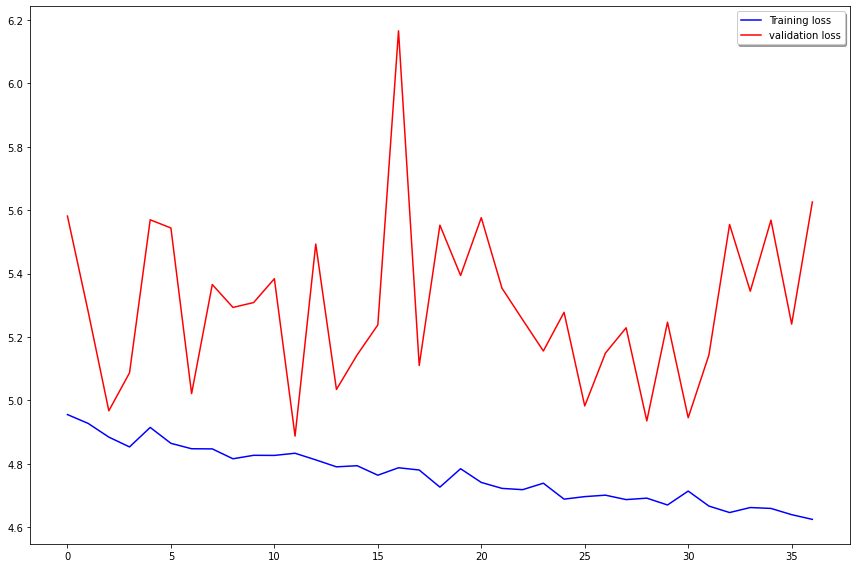

In [ ]:
# Definimos una gráfica de tamaño 12x8
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Graficamos el valor de pérdidas tanto en validación como en entrenamiento. Recordemos que se eligió la métrica MeanAbsoluteError
ax1.plot(history_aug.history['mean_absolute_error'], color='b', label="Training Loss")
ax1.plot(history_aug.history['val_mean_absolute_error'], color='r',label="Validation Loss")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Podemos ver que durante la fase de entrenamiento, el modelo empieza con un valor de pérdidas que se sitúa en torno a 5. Con el paso de las épocas, este valor va disminuyendo, y al final del entrenamiento se sitúa en torno a 4.7.

Durante la fase de validación, el modelo empieza con un valor de pérdidas que se sitúa en torno a 5.6. Con el paso de las épocas, vemos que el modelo va aprendiendo. En esta fase de entrenamiento, el mejor modelo se consiguió en la época 12, con un valor de pérdidas de 4.89.

Guardamos estos resultados para no perderlos y poder graficarlo todo en conjunto al final de todas las fases de las que se componga el entrenamiento.


In [ ]:
# Convertimos el diccionario history.history en dataframe   
hist_df = pd.DataFrame(history_aug.history) 

# y lo guardamos en un fichero CSV
hist_csv_file = 'history_aug.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### 4.2.4 VGG16: entrenamiento fase 4.

Empezamos importando el modelo guardado en la fase anterior:

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/TFM/my_best_model.epoch12-loss4.89.hdf5")

Seguimos entrenando el modelo durante 40 épocas más. Las métricas de evaluación, función de pérdidas y método de callback no hace falta volverlos a definir, puesto que se usarán los mismos que se usaron en la fase anterior.

In [ ]:
history_aug = model.fit(train_images, batch_size = BATCH_SIZE ,epochs = 40, shuffle=True, callbacks = callbacks, validation_data=val_images)

Epoch 1/40
1144/1144 [==============================] - ETA: 0s - loss: 4.7856 - mean_absolute_error: 4.7856
Epoch 1: val_loss improved from inf to 5.36774, saving model to my_best_model.epoch01-loss5.37.hdf5
1144/1144 [==============================] - 358s 304ms/step - loss: 4.7856 - mean_absolute_error: 4.7856 - val_loss: 5.3677 - val_mean_absolute_error: 5.3677 - lr: 0.0010
Epoch 2/40
1144/1144 [==============================] - ETA: 0s - loss: 4.7848 - mean_absolute_error: 4.7848
Epoch 2: val_loss improved from 5.36774 to 5.23925, saving model to my_best_model.epoch02-loss5.24.hdf5
1144/1144 [==============================] - 337s 295ms/step - loss: 4.7848 - mean_absolute_error: 4.7848 - val_loss: 5.2393 - val_mean_absolute_error: 5.2393 - lr: 0.0010
Epoch 3/40
1144/1144 [==============================] - ETA: 0s - loss: 4.7414 - mean_absolute_error: 4.7414
Epoch 3: val_loss improved from 5.23925 to 4.91246, saving model to my_best_model.epoch03-loss4.91.hdf5
1144/1144 [==========

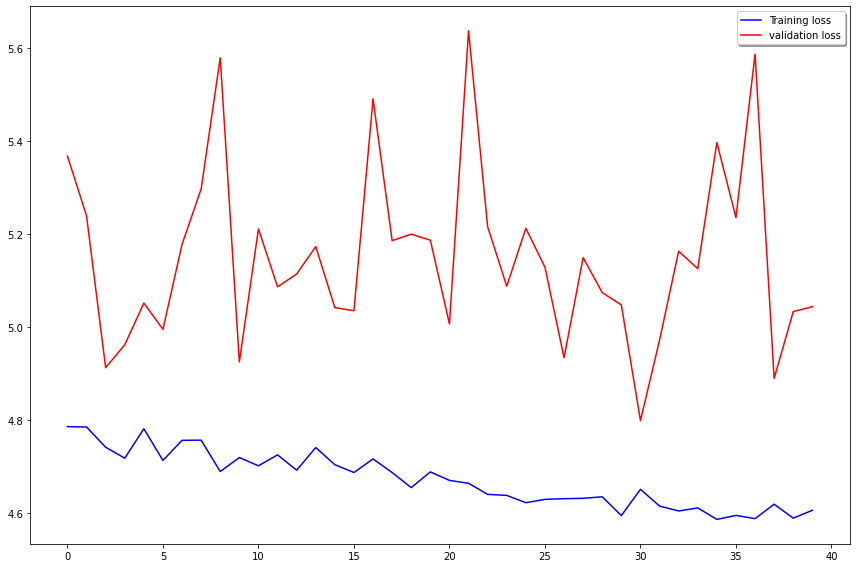

In [ ]:
# Definimos una gráfica de tamaño 12x8
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Graficamos el valor de pérdidas tanto en validación como en entrenamiento. Recordemos que se eligió la métrica MeanAbsoluteError
ax1.plot(history_aug.history['mean_absolute_error'], color='b', label="Training Loss")
ax1.plot(history_aug.history['val_mean_absolute_error'], color='r',label="Validation Loss")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Podemos ver que durante la fase de entrenamiento, el modelo empieza con un valor de pérdidas que se sitúa en torno a 4.8. Con el paso de las épocas, este valor va disminuyendo, y al final del entrenamiento se sitúa en torno a 4.6. También, podemos observar que el ritmo de aprendizaje en entrenamiento va disminuyendo.

Durante la validación, el modelo empieza con un valor de pérdidas que se sitúa en torno a 5.4. Con el paso de las épocas, vemos que el modelo va aprendiendo. En esta fase de entrenamiento, el mejor modelo se consiguió en la época 31, con un valor de pérdidas de 4.80.

Guardamos estos resultados para no perderlos y poder graficarlo todo en conjunto al final de todas las fases de las que se componga el entrenamiento.


In [ ]:
# Convertimos el diccionario history.history en dataframe   
hist_df = pd.DataFrame(history_aug.history) 

# y lo guardamos en un fichero CSV
hist_csv_file = 'history_aug.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### 4.2.5 VGG16: entrenamiento fase 5.

Empezamos importando el modelo guardado en la fase anterior:

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/TFM/my_best_model.epoch31-loss4.80.hdf5")

Seguimos entrenando el modelo durante 40 épocas más. Las métricas de evaluación, función de pérdidas y método de callback no hace falta volverlos a definir, puesto que se usarán los mismos que se usaron en la fase anterior.

In [ ]:
history_aug = model.fit(train_images, batch_size = BATCH_SIZE ,epochs = 40, shuffle=True, callbacks = callbacks, validation_data=val_images)

Epoch 1/40
1144/1144 [==============================] - ETA: 0s - loss: 4.5823 - mean_absolute_error: 4.5823
Epoch 1: val_loss improved from inf to 4.95716, saving model to my_best_model.epoch01-loss4.96.hdf5
1144/1144 [==============================] - 375s 319ms/step - loss: 4.5823 - mean_absolute_error: 4.5823 - val_loss: 4.9572 - val_mean_absolute_error: 4.9572 - lr: 0.0010
Epoch 2/40
1144/1144 [==============================] - ETA: 0s - loss: 4.5889 - mean_absolute_error: 4.5889
Epoch 2: val_loss did not improve from 4.95716
1144/1144 [==============================] - 354s 309ms/step - loss: 4.5889 - mean_absolute_error: 4.5889 - val_loss: 4.9684 - val_mean_absolute_error: 4.9684 - lr: 0.0010
Epoch 3/40
1144/1144 [==============================] - ETA: 0s - loss: 4.5513 - mean_absolute_error: 4.5513
Epoch 3: val_loss improved from 4.95716 to 4.85908, saving model to my_best_model.epoch03-loss4.86.hdf5
1144/1144 [==============================] - 352s 308ms/step - loss: 4.5513 - 

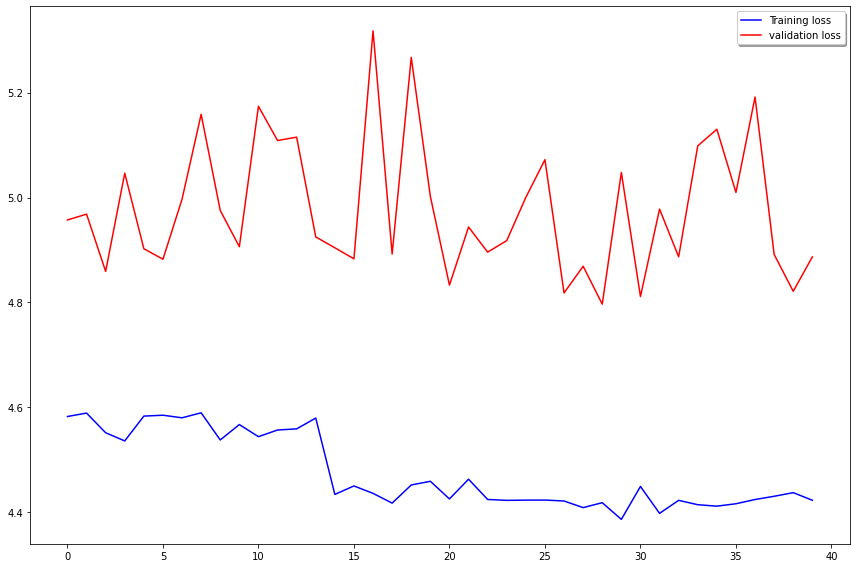

In [ ]:
# Definimos una gráfica de tamaño 12x8
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Graficamos el valor de pérdidas tanto en validación como en entrenamiento. Recordemos que se eligió la métrica MeanAbsoluteError
ax1.plot(history_aug.history['mean_absolute_error'], color='b', label="Training Loss")
ax1.plot(history_aug.history['val_mean_absolute_error'], color='r',label="Validation Loss")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Podemos ver que durante la fase de entrenamiento, el modelo empieza con un valor de pérdidas que se sitúa en torno a 4.6. Con el paso de las épocas, este valor va disminuyendo, y al final del entrenamiento se sitúa en torno a 4.4.

Durante la fase de validación, el modelo empieza con un valor de pérdidas que se sitúa en torno a 4.95. Con el paso de las épocas, vemos que el modelo no mejora los resultados de la fase anterior, ya que el valor de pérdidas más bajo ocurre en la época 23, con valor de 4.80.

Guardamos estos resultados para no perderlos y poder graficarlo todo en conjunto al final de todas las fases de las que se componga el entrenamiento.


In [ ]:
# Convertimos el diccionario history.history en dataframe   
hist_df = pd.DataFrame(history_aug.history) 

# y lo guardamos en un fichero CSV
hist_csv_file = 'history_aug.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### 4.2.6 VGG16: entrenamiento fase 6.

Empezamos importando el modelo guardado en la fase anterior:

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/TFM/my_best_model.epoch29-loss4.80.hdf5")

Seguimos entrenando el modelo durante 40 épocas más. Las métricas de evaluación, función de pérdidas y método de callback no hace falta volverlos a definir, puesto que se usarán los mismos que se usaron en la fase anterior.

In [ ]:
history_aug = model.fit(train_images, batch_size = BATCH_SIZE ,epochs = 40, shuffle=True, callbacks = callbacks, validation_data=val_images)

Epoch 1/40
1144/1144 [==============================] - ETA: 0s - loss: 4.3957 - mean_absolute_error: 4.3957
Epoch 1: val_loss improved from inf to 4.89328, saving model to my_best_model.epoch01-loss4.89.hdf5
1144/1144 [==============================] - 371s 315ms/step - loss: 4.3957 - mean_absolute_error: 4.3957 - val_loss: 4.8933 - val_mean_absolute_error: 4.8933 - lr: 5.0000e-04
Epoch 2/40
1144/1144 [==============================] - ETA: 0s - loss: 4.3984 - mean_absolute_error: 4.3984
Epoch 2: val_loss did not improve from 4.89328
1144/1144 [==============================] - 354s 310ms/step - loss: 4.3984 - mean_absolute_error: 4.3984 - val_loss: 5.1094 - val_mean_absolute_error: 5.1094 - lr: 5.0000e-04
Epoch 3/40
1144/1144 [==============================] - ETA: 0s - loss: 4.3674 - mean_absolute_error: 4.3674
Epoch 3: val_loss did not improve from 4.89328
1144/1144 [==============================] - 351s 307ms/step - loss: 4.3674 - mean_absolute_error: 4.3674 - val_loss: 4.9589 - 

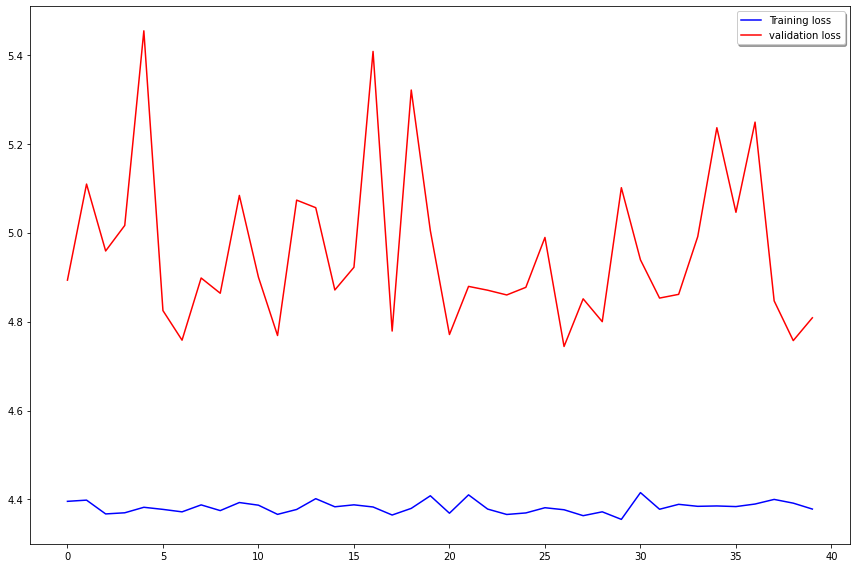

In [ ]:
# Definimos una gráfica de tamaño 12x8
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Graficamos el valor de pérdidas tanto en validación como en entrenamiento. Recordemos que se eligió la métrica MeanAbsoluteError
ax1.plot(history_aug.history['mean_absolute_error'], color='b', label="Training Loss")
ax1.plot(history_aug.history['val_mean_absolute_error'], color='r',label="Validation Loss")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Podemos ver que durante la fase de entrenamiento, el modelo empieza con un valor de pérdidas que se sitúa en torno a 4.39. Con el paso de las épocas, este valor apenas se reduce, situándose al final del entrenamiento  en torno a 4.37.

Durante la fase de validación, el modelo empieza con un valor de pérdidas que se sitúa en torno a 4.95. Con el paso de las épocas, vemos que el modelo mejora los resultados de la fase anterior, ya que el valor de pérdidas más bajo ocurre en la época 27, con valor de 4.74.

Sin embargo, observando la curva de entrenamiento, apreciamos que el modelo no va a mejorar significativamente con el paso de las épocas. Por lo tanto, dejamos de entrenar este modelo.

Guardamos estos resultados para no perderlos y poder graficarlo todo en conjunto al final de todas las fases de las que se componga el entrenamiento.


In [ ]:
# Convertimos el diccionario history.history en dataframe   
hist_df = pd.DataFrame(history_aug.history) 

# y lo guardamos en un fichero CSV
hist_csv_file = 'history_aug.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### 4.1.7 VGG16: análisis de resultados.

Una vez acabado el entrenamiento del primer modelo, vamos a graficar los resultados obtenidos durante las 240 épocas que ha durado el entrenamiento.


Importamos los CSV guardados:

In [ ]:
history1 = pd.read_csv("/content/drive/MyDrive/TFM/history1.csv")
history2 = pd.read_csv("/content/drive/MyDrive/TFM/history2.csv")
history3 = pd.read_csv("/content/drive/MyDrive/TFM/history3.csv")
history4 = pd.read_csv("/content/drive/MyDrive/TFM/history4.csv")
history5 = pd.read_csv("/content/drive/MyDrive/TFM/history5.csv")
history6 = pd.read_csv("/content/drive/MyDrive/TFM/history6.csv")

Agrupamos los resultados en un único dataframe:

In [ ]:
final_dataframe = pd.concat([history1, history2, history3, history4, history5, history6]).reset_index(drop=True) 

Y graficamos los valores de pérdidas:

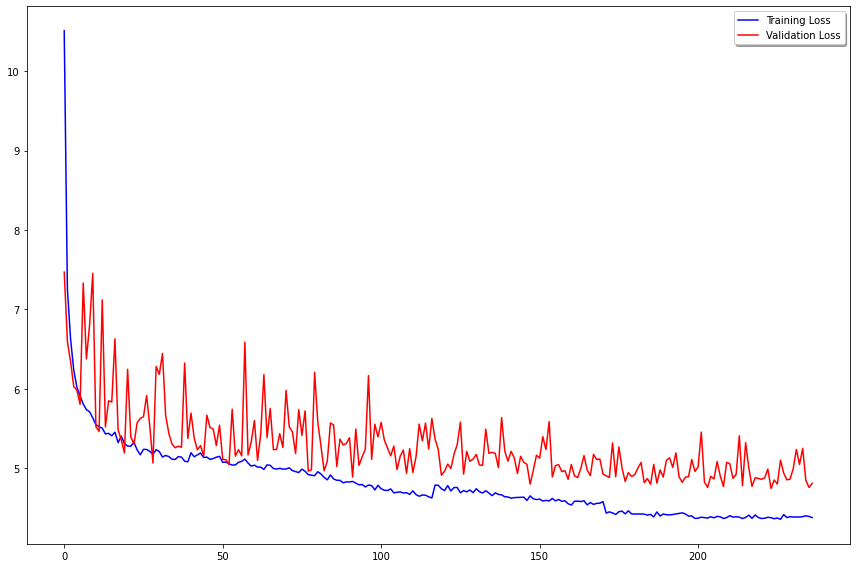

In [ ]:
# Definimos una gráfica de tamaño 12x8
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Graficamos el valor de pérdidas tanto en validación como en entrenamiento
ax1.plot(final_dataframe['mean_absolute_error'], color='b', label="Training Loss")
ax1.plot(final_dataframe['val_mean_absolute_error'], color='r',label="Validation Loss")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Observando la curva de pérdidas durante la etapa de entrenamiento y validación, vemos que a lo largo de las distintas épocas el valor de pérdida va disminuyendo progresivamente. Al final de la etapa de validación, vemos que el valor de pérdidas se sitúa en torno a 4.8, mientras que el valor de pérdidas en entrenamiento acaba en torno a 4.3.
También, observamos que el valor de pérdidas en validación y entrenamiento parec ir estabilizándose con el paso de las épocas, por lo que todo parece indicar que este modelo tiene mejor comportamiento que el modelo CNN propuesto.


Vamos a pasar a evaluar el modelo y a hacer predicciones sobre los datos de test. Para ello, importamos el modelo que menor valor de pérdias ha conseguido. Recordemos que el mejor modelo se consiguió en la fase 3 de entrenamiento, con un valor de pérdidas en validación de 3.8.


In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/TFM/my_best_model.epoch27-loss4.74.hdf5")

Evaluamos:

In [ ]:
model.evaluate(test_images)

4576/4576 [==============================] - 46s 10ms/step - loss: 4.7626 - mean_absolute_error: 4.7626


[4.762634754180908, 4.762634754180908]

Hacemos predicciones:

In [ ]:
predictions = model.predict(test_images)

4576/4576 [==============================] - 38s 8ms/step


Las guardamos en un dataframe:

In [ ]:
df_predictions = pd.DataFrame(data = predictions, columns = ['Predictions'])

Y graficamos 15 imágenes aleatorias junto con los valores de pérdida de potencia predichos y los valores de pérdida de potencia reales:

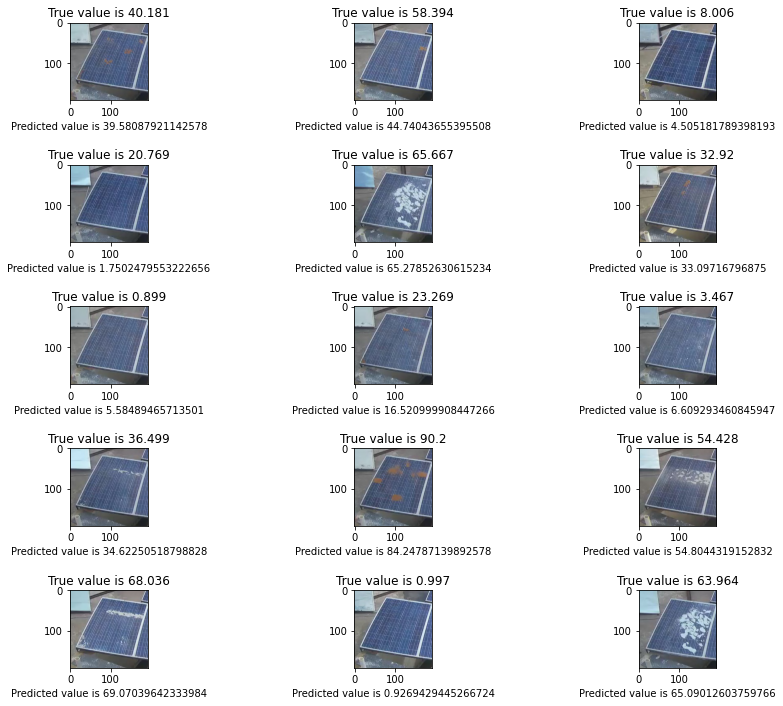

In [ ]:
# Número de filas
num_rows = 5

# Número de columnas
num_cols = 3

len(df_test_estratificado)

num_images = num_rows*num_cols
# Definimos el tamaño de la figura en función del número de columnas y filas
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):

  # Creamos la ventana de graficación
  plt.subplot(num_rows, 2*num_cols, 2*i+1)

  # Elegimos una imagen aleatoria
  sample = random.choice(range(len(df_test_estratificado)))
  
  # Graficamos la imagen elegida
  image = plt.imread('/content/output/test/PanelImages/' + df_test_estratificado['Image Name'][sample])
  plt.imshow(image, cmap=plt.cm.binary)

  # Añadimos el valor real y la predicción de pérdida de potencia
  plt.title('True value is {}'.format(df_test_estratificado['Power Loss'][sample]))
  plt.xlabel('Predicted value is {}'.format(df_predictions['Predictions'][sample]))

plt.tight_layout()
plt.show()

Analizando las predicciones vemos que, para la mitad de las imágenes, el valor predicho es cercano al valor real. Sin embargo, también se puede observar que hay valores predichos que se alejan del valor verdadero.

Por último, vamos a comprobar como se comporta el modelo con imágenes de paneles solares diferentes a las usadas hasta ahora.

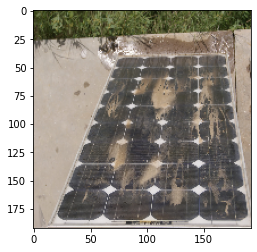

In [ ]:
# Leemos la imagen
img = cv2.imread('/content/1.jpg')

# Convertimos la imagen a RGB ya que por defecto CV2 lee en formato BGR
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionamos al tamaño de imagen que la red necesita
dsize = (192, 192)
output = cv2.resize(RGB_img, dsize)

# Normalizamos la imagen para que los coeficientes RGB estén en el rango [0,1]
norm_image = cv2.normalize(output, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Graficamos la imagen
plt.imshow(norm_image)

In [ ]:
# Añadimos la dimensión perteneciente al Batch ya que hay que respetar el formato que espera la red
img = np.expand_dims(norm_image, axis=0)

# Hacemos la predicción
model.predict(img)

1/1 [==============================] - 0s 147ms/step


array([[89.27267]], dtype=float32)

Vemos que la red da una predicción de pérdida de potencia del 51.4%. Desconocemos el valor real de pérdida de potencia de este panel de la imagen, por lo que no podemos saber si el valor de predicción que nos ha dado nuestro se aleja de la realidad. Aun así, vemos que la red da un valor coherente, puesto que en la imagen se aprecia suciedad, lo que provocaría una pérdida de potencia.

Comprobamos con otra imagen.


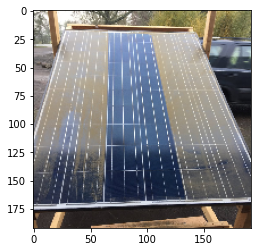

In [ ]:
# Leemos la imagen
img = cv2.imread('/content/2.jpeg')

# Convertimos la imagen a RGB ya que por defecto CV2 lee en formato BGR
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionamos al tamaño de imagen que la red necesita
dsize = (192, 192)
output = cv2.resize(RGB_img, dsize)

# Normalizamos la imagen para que los coeficientes RGB estén en el rango [0,1]
norm_image = cv2.normalize(output, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Graficamos la imagen
plt.imshow(norm_image)

In [ ]:
# Añadimos la dimensión perteneciente al Batch ya que hay que respetar el formato que espera la red
img = np.expand_dims(norm_image, axis=0)

# Hacemos la predicción
model.predict(img)

1/1 [==============================] - 0s 26ms/step


array([[30.305593]], dtype=float32)

Nuevamente, desconocemos el valor real de pérdida de potencia de este panel de la imagen. Vemos que la red da una predicción de pérdida de potencia del 75.8%.No podemos saber si el valor de predicción que nos ha dado nuestro se aleja de la realidad. Aun así, vemos que la red da un valor coherente, puesto que en la imagen se aprecia suciedad, lo que provocaría una pérdida de potencia.


Por último, vamos a introducir una imagen de un panel que, aparentemente, no deberia presentar pérdida de potencia debido a suciedad presente en el panel.

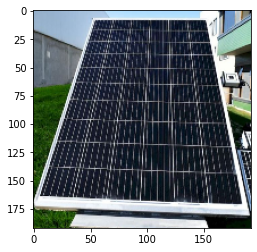

In [ ]:
# Leemos la imagen
img = cv2.imread('/content/5.JPG')

# Convertimos la imagen a RGB ya que por defecto CV2 lee en formato BGR
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionamos al tamaño de imagen que la red necesita
dsize = (192, 192)
output = cv2.resize(RGB_img, dsize)

# Normalizamos la imagen para que los coeficientes RGB estén en el rango [0,1]
norm_image = cv2.normalize(output, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Graficamos la imagen
plt.imshow(norm_image)

In [ ]:
# Añadimos la dimensión perteneciente al Batch ya que hay que respetar el formato que espera la red
img = np.expand_dims(norm_image, axis=0)

# Hacemos la predicción
model.predict(img)

1/1 [==============================] - 0s 28ms/step


array([[6.6408563]], dtype=float32)

Vemos que la red da una predicción de pérdida de potencia del 6.6%. Aunque desconocemos el valor real de pérdida de potencia, no parece que este panel deba tener un valor alto. Aun así, vemos que la red da un valor coherente.